# CONFLUENCE Tutorial - 1: Point-Scale Workflow (SNOTEL Example)

## Introduction

Welcome to CONFLUENCE, a framework designed to advance reproducible computational hydrology through standardized, modular workflows that seamlessly scale from point-scale process validation to continental-scale large-sample studies. The CONFLUENCE philosophy centers on model-agnostic data preprocessing, configuration-driven experiments, and systematic workflow orchestration to ensure that hydrological research is transparent, reproducible, and scientifically rigorous. This tutorial series is organized into four progressive sections: **Section 01** focuses on point-scale modeling and vertical flux simulations to establish fundamental process understanding; **Section 02** expands to basin-scale modeling with various spatial discretization schemes and routing processes; **Section 03** advances to regional and multi-watershed simulations extending to continental scales; and **Section 04** demonstrates large-sample studies across extensive datasets for comparative hydrology research. This first notebook (Tutorial 01a) follows a systematic 5-step workflow: (1) experiment initialization and reproducible setup, (2) geospatial domain definition and spatial discretization, (3) input data preprocessing through the model-agnostic framework, (4) model instantiation and process-based simulation, and (5) model evaluation and process validation, establishing the foundational principles that will scale throughout the entire tutorial series.

### The Scientific Importance of Point-Scale Modeling

Point-scale modeling is the building block of distributed hydrological modeling, where vertical energy and water balance processes are simulated at a single location without the complexities of lateral flow routing. This approach is scientifically valuable for several reasons:

1. **Process Understanding**: Point-scale simulations isolate vertical processes (precipitation, evapotranspiration, snowmelt, infiltration, and soil moisture dynamics), allowing researchers to evaluate model physics without confounding effects from spatial heterogeneity and routing processes.

2. **Model Validation**: Single-point simulations provide controlled conditions for testing model assumptions and parameter sensitivity, serving as a prerequisite for successful distributed modeling applications.

3. **Observational Constraints**: Point-scale modeling leverages high-quality, long-term observational datasets to constrain model parameters and validate process representations before scaling to larger, distributed domains.

### Case Study: Paradise SNOTEL Station

This tutorial demonstrates  point-scale simulations in CONFLUENCE using the Paradise SNOTEL station (ID: 602) in Washington State. Located at 1,630 m elevation in the Cascade Range, this site represents a transitional snow climate with observations of both Snow Water Equivilalent (SWE) and Soil Moisture (SM) at four depths.

## Learning Objectives

By the end of this tutorial, you will:

1. **Understand CONFLUENCE architecture**: Learn how the modular framework manages complex hydrological modeling workflows
2. **Configure point-scale simulations**: Set up CONFLUENCE for single-point SUMMA simulations 
3. **Evaluate model performance**: Compare simulated and observed snow water equivalent and soil moisture using quantitative metrics

This foundation in point-scale modeling prepares you for more complex distributed modeling applications while building confidence in model physics and parameter estimation approaches.

# Step 1: Experiment Initialization and Reproducible Workflow Setup

## Scientific Context
Reproducible hydrological research requires systematic organization of data, code, and results. Modern computational hydrology faces several challenges:

- Provenance Tracking: Understanding how results were generated, which data were used, and what decisions were made
- Experiment Scaling: Moving from single-site studies to large sample investigations across hundreds of watersheds
- Collaborative Research: Enabling multiple researchers to build upon previous work
- Long-term Maintenance: Ensuring experiments remain accessible and reproducible years later

Point-scale modeling serves as the foundation for larger distributed studies. The organizational principles established here directly enable the large-sample hydrological studies we'll explore in Tutorial 4, where these same workflows scale across thousands of sites simultaneously.

## CONFLUENCE Implementation
CONFLUENCE addresses reproducibility through three core principles:

- Configuration-Driven Workflows: All experiment settings are stored in human-readable YAML files that serve as complete experiment documentation
- Standardized Directory Structure: Consistent organization enables automated processing and easy navigation across studies
- Modular Architecture: Specialized managers handle different workflow components, making the system maintainable and extensible

The framework automatically creates detailed logs, maintains data provenance, and ensures that any experiment can be reproduced from its configuration file alone.

In [1]:
# First we import the libraries we'll need in this tutorial
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import contextily as cx
import xarray as xr
import numpy as np

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

print("=== CONFLUENCE Tutorial - 1: Point-Scale Workflow - SNOTEL example ===")
print(f"CONFLUENCE path: {confluence_path}")
print(f"Tutorial started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

=== CONFLUENCE Tutorial - 1: Point-Scale Workflow - SNOTEL example ===
CONFLUENCE path: /Users/darrieythorsson/compHydro/code/CONFLUENCE
Tutorial started: 2025-08-28 14:59:34


## Configuration Generation and Experiment Design
The configuration file serves as the complete experimental protocol, documenting every decision. This approach ensures that experiments are:

- Fully documented: Every setting is explicit and versioned
- Easily modified: Parameter sensitivity studies require only config changes
- Shareable: Colleagues can reproduce exact experiments
- Scalable: The same structure works for single sites or continental studies
- Repeatable: The same structure can be repeated to facilitate large sample studies

## SNOTEL Point Scale Experiment Setup
To get our point scale model setup we'll make appropriate changes to the default point scale config template in ../0_config_files/config_point_template.yaml

In [9]:
# Set directory paths 
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/Users/darrieythorsson/compHydro/data/CONFLUENCE_data') 
#CONFLUENCE_DATA_DIR = Path('/path/to/your/CONFLUENCE_data') 

# Load template configuration for point-scale modeling
config_template_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_point_template.yaml'

# Read and customize configuration
with open(config_template_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update paths and core experiment settings
config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)
config_dict['BOUNDING_BOX_COORDS'] = str('46.781/-121.751/46.779/-121.749')
config_dict['POUR_POINT_COORDS'] = str('46.78/-121.75')
config_dict['DOMAIN_DEFINITION_METHOD'] = "point"
config_dict['DOWNLOAD_SNOTEL'] = 'True'
config_dict['HYDROLOGICAL_MODEL'] = "SUMMA"
config_dict['FORCING_DATASET'] = "ERA5"
config_dict['SUPPLEMENT_FORCING'] = 'True'
config_dict['EXPERIMENT_TIME_START'] = "1981-01-01 01:00"
config_dict['EXPERIMENT_TIME_END'] = "2019-12-31 23:00"
config_dict['DOMAIN_NAME'] = 'paradise'
config_dict['EXPERIMENT_ID'] = 'point_scale_tutorial'

# Save configuration 
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_point_notebook.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f, default_flow_style=False, sort_keys=False)

print(f"\n✅ Configuration saved to: {temp_config_path}")


✅ Configuration saved to: /Users/darrieythorsson/compHydro/code/CONFLUENCE/0_config_files/config_point_notebook.yaml


## CONFLUENCE System Initialization
Now we are ready to create an instantiation of CONFLUENCE using our new configuration file. 

In [10]:
# Initialize CONFLUENCE with the experiment configuration
confluence = CONFLUENCE(temp_config_path)


15:01:13 │ ============================================================
15:01:13 ● CONFLUENCE Logging Initialized
15:01:13 ● Domain: paradise
15:01:13 ● Experiment ID: point_scale_tutorial
15:01:13 ● Log Level: INFO
15:01:13 ● Log File: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/_workLog_paradise/confluence_general_paradise_20250828_150113.log

15:01:13 │ ============================================================
15:01:13 ● Configuration logged to: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/_workLog_paradise/config_paradise_20250828_150113.yaml
15:01:13 ● Initializing CONFLUENCE system
15:01:13 ● Configuration loaded from: /Users/darrieythorsson/compHydro/code/CONFLUENCE/0_config_files/config_point_notebook.yaml
15:01:13 ● Creating point domain shapefile from bounding box coordinates
15:01:13 ● Point domain shapefile created successfully: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/river_basin

## Project Structure Creation and Organization
We can now use CONFLUENCE to setup a project directory for our experiment. 

In [11]:
# Initialize project structure
project_dir = confluence.managers['project'].setup_project()

print(f"\n📁 Project root created: {project_dir}")

# Create spatial reference point (SNOTEL station location)
pour_point_path = confluence.managers['project'].create_pour_point()

print(f"📍 Pour point created: {pour_point_path}")
print(f"   → Location: {config_dict['POUR_POINT_COORDS']} (Paradise SNOTEL)")

# Display the created directory structure
print(f"\n=== Standardized Directory Structure ===")

def display_directory_tree(path, prefix="", max_depth=2, current_depth=0):
    """Display directory tree with scientific context"""
    if current_depth >= max_depth:
        return
    
    items = sorted([item for item in path.iterdir() if item.is_dir()])
    for i, item in enumerate(items):
        is_last = i == len(items) - 1
        current_prefix = "└── " if is_last else "├── "
        print(f"{prefix}{current_prefix}{item.name}")
        
        # Add scientific context for key directories
        if item.name == "forcing":
            print(f"{prefix}{'    ' if is_last else '│   '}    → Meteorological input data")
        elif item.name == "observations": 
            print(f"{prefix}{'    ' if is_last else '│   '}    → Validation datasets (SNOTEL, streamflow)")
        elif item.name == "simulations":
            print(f"{prefix}{'    ' if is_last else '│   '}    → Model output organized by experiment")
        elif item.name == "attributes":
            print(f"{prefix}{'    ' if is_last else '│   '}    → Geospatial characteristics (elevation, soil, land cover)")
        elif item.name == "shapefiles":
            print(f"{prefix}{'    ' if is_last else '│   '}    → Spatial domains and discretization")
            
        if current_depth < max_depth - 1:
            extension = "    " if is_last else "│   "
            display_directory_tree(item, prefix + extension, max_depth, current_depth + 1)

display_directory_tree(project_dir, max_depth=2)

15:01:17 ● Setting up project for domain: paradise
15:01:17 ● Project directory created at: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise

📁 Project root created: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise
15:01:17 ● Pour point shapefile created successfully: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/pour_point/paradise_pourPoint.shp
📍 Pour point created: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/pour_point/paradise_pourPoint.shp
   → Location: 46.78/-121.75 (Paradise SNOTEL)

=== Standardized Directory Structure ===
├── _workLog_paradise
├── attributes
│       → Geospatial characteristics (elevation, soil, land cover)
│   ├── elevation
│   ├── landclass
│   └── soilclass
├── forcing
│       → Meteorological input data
│   ├── basin_averaged_data
│   ├── raw_data
│   └── raw_data_em_earth
├── observations
│       → Validation datasets (SNOTEL, streamflow)
│  

# Step 2: Geospatial Domain Definition and Spatial Discretization

## Scientific Context
Spatial representation is fundamental to hydrological modeling, determining how we conceptualize the landscape and partition it into computational units. The choice of spatial discretization profoundly affects:

- Process Representation: How we capture spatial heterogeneity in climate, topography, vegetation, and soils
- Model Complexity: The trade-off between process detail and computational efficiency
- Scale Dependencies: How processes manifest differently at point, hillslope, and watershed scales
- Validation Strategy: What observations are appropriate for model evaluation

For point-scale modeling, we deliberately minimize spatial complexity to isolate vertical processes. This creates a controlled environment where energy and water balance physics can be evaluated without the confounding effects of lateral flow, spatial heterogeneity, or routing processes.

The spatial representation we establish here contrasts with the distributed watersheds we'll explore in Tutorial 2, where complex topography drives spatial patterns in precipitation, radiation, and runoff generation.

## CONFLUENCE Implementation
CONFLUENCE handles spatial domain definition through three components:

- Attribute Acquisition: Systematic collection of the geospatial characteristics we need to configure our hydrological models (elevation, soil properties, land cover) using standardized datasets
- Domain Delineation: Creation of the primary computational boundary (Grouped Response Units - GRUs)
- Domain Discretization: Subdivision into Hydrologic Response Units (HRUs) based on landscape similarity

For point-scale studies, this process creates a minimal spatial representation:

- Bounding Box: 0.001° × 0.001° square centered on station coordinates
- Single GRU: One computational unit representing the station footprint
- Single HRU: No further subdivision needed for point-scale physics

The same framework scales seamlessly from this minimal representation to complex distributed watersheds with hundreds of HRUs as we'll explore in Tutorials 2 and 3.

## Step 2a: Geospatial Attribute Acquisition
Attributes provide the physical characteristics needed to parameterize model physics. Even for point-scale modeling, we need elevation, soil properties, and vegetation characteristics to constrain energy and water balance processes.

CONFLUENCE uses [gistool (Keshavaraz et al., 2025](https://github.com/CH-Earth/gistool) to subset and aquire the required data.

In [ ]:
# Acquire geospatial attributes
print(f"\n⬇️  Acquiring attributes through gistool (Model Agnostic Framework)...")
print("   → This may take several minutes ")

# confluence.managers['data'].acquire_attributes()

print("✅ Attribute acquisition complete")    

## Step 2b: Domain Delineation (GRU Creation)
Domain delineation creates the primary computational boundary. For point-scale modeling, this is simply a geometric square around our station location, but the same process scales to complex watershed delineation for distributed modeling.

In [13]:
print("Creating primary computational boundary...")

watershed_path = confluence.managers['domain'].define_domain()

print(f"✅ Domain delineation complete")

Creating primary computational boundary...
15:01:26 ● Domain definition workflow starting with: point
15:01:26 ● Point domain shapefile already exists: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/river_basins/paradise_riverBasins_point.shp
15:01:26 ● Domain definition completed using method: point
15:01:26 ● Domain map saved to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/plots/domain/domain_map.png
15:01:26 ● Domain definition workflow finished
✅ Domain delineation complete


## Step 2c: Domain Discretization (HRU Creation)
Discretization subdivides GRUs into Hydrologic Response Units based on landscape similarity. For point-scale modeling, we maintain a 1:1 relationship (1 GRU = 1 HRU), but this step demonstrates the framework that enables more complex spatial representations which we will encounter in later notebook sections.

In [14]:
print("Creating Hydrologic Response Units for model execution...")

hru_path = confluence.managers['domain'].discretize_domain()

print(f"✅ Domain discretization complete")

Creating Hydrologic Response Units for model execution...
15:01:28 ● Discretizing domain using method: GRUs
15:01:28 ● Starting domain discretization using attributes: ['GRUs']

15:01:28 │ Step 1/2: Running single attribute discretization method
15:01:28 ● config domain name paradise
15:01:28 ● Calculating mean elevation for each HRU
15:01:28 ● DEM CRS: EPSG:4326
15:01:28 ● Shapefile CRS: EPSG:4326
15:01:28 ● CRS match - no reprojection needed
15:01:28 ● Successfully calculated elevation statistics for 1 HRUs
15:01:28 ● Calculated centroids in WGS84: lat range 46.780000 to 46.780000, lon range -121.750000 to -121.750000
15:01:28 ● GRUs saved as HRUs to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment/paradise_HRUs_GRUs.shp
15:01:29 ● HRU plot saved to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/plots/catchment/paradise_HRUs_as_GRUs.png

15:01:29 │ Step 2/2: Sorting catchment shape
15:01:29 ● Sorting catchment shape
15:

## Spatial Visualization

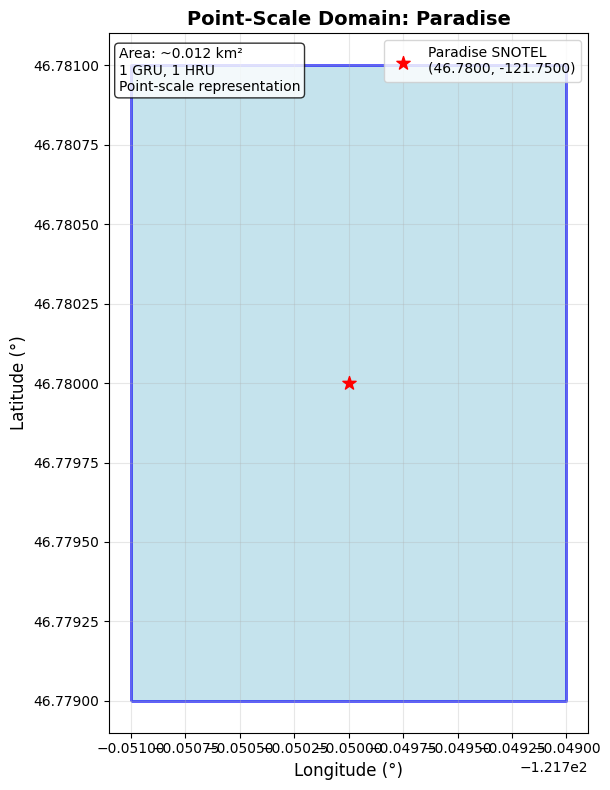

✅ Spatial visualization complete


In [15]:
# Load spatial data
hru_path = confluence.project_dir / "shapefiles" / "catchment" / f"{config_dict['DOMAIN_NAME']}_HRUs_{config_dict['DOMAIN_DISCRETIZATION']}.shp"
hru_gdf = gpd.read_file(hru_path)

# Create simple plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot HRU
hru_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', linewidth=2, alpha=0.7)

# Add station point
station_coords = config_dict['POUR_POINT_COORDS'].split('/')
station_lat, station_lon = float(station_coords[0]), float(station_coords[1])
ax.scatter(station_lon, station_lat, c='red', s=100, marker='*', 
          label=f'Paradise SNOTEL\n({station_lat:.4f}, {station_lon:.4f})', zorder=5)

# Styling
ax.set_title(f'Point-Scale Domain: {config_dict["DOMAIN_NAME"].title()}', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add annotation
ax.text(0.02, 0.98, f"Area: ~0.012 km²\n1 GRU, 1 HRU\nPoint-scale representation", 
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

print("✅ Spatial visualization complete")

# Step 3: Input Data Preprocessing and Model-Agnostic Framework
## Scientific Context
Input data preprocessing represents a critical but often overlooked component of hydrological modeling that profoundly affects model performance and scientific conclusions. Traditional approaches tightly couple data preprocessing with specific models, creating several scientific and practical challenges:

- Model Comparison Barriers: Different preprocessing approaches make it difficult to determine whether performance differences arise from model physics or data preparation
- Reproducibility Issues: Model-specific preprocessing pipelines are often poorly documented and difficult to reproduce
- Research Inefficiency: Duplicated preprocessing effort across modeling studies
- Benchmarking Limitations: Inability to evaluate models against consistent baselines

The Model-Agnostic Framework (MAF) philosophy addresses these challenges by separating data preparation from model execution, creating a standardized pipeline that serves multiple modeling applications.

## CONFLUENCE Implementation Philosophy
CONFLUENCE implements a two-stage preprocessing architecture:
Stage 1: Model-Agnostic Preprocessing

- Standardized Data Sources: Consistent meteorological and geospatial datasets
- Unified Spatial Framework: Common geospatial operations across all models
- Quality-Controlled Outputs: Standardized formats with documented provenance
- Reusable Products: Same preprocessed data serves multiple models and analyses

Stage 2: Model-Specific Preprocessing

- Format Translation: Convert standardized outputs to model-required formats
- Model Configuration: Apply model-specific parameter assignments and settings
- Initialization: Prepare model-specific initial conditions and control files

This separation enables true model intercomparison studies, automated benchmarking, and scalable research workflows that maintain scientific rigor while maximizing efficiency.

## Step 3a: Meteorological Forcing Data Acquisition
Meteorological forcing drives all hydrological models, making standardized acquisition critical for reproducible research. CONFLUENCE leverages the Model-Agnostic Framework's [datatool (Keshavarz et al., 2025)](https://github.com/CH-Earth/datatool) to access quality-controlled, globally-consistent datasets.

In [ ]:
print("Acquiring standardized meteorological forcing through datatool...")

# confluence.managers['data'].acquire_forcings()

print("✅ Forcing data acquisition complete")

## Step 3b: Observational Data Processing
Observational data provides the ground truth for model evaluation. CONFLUENCE systematically acquires and processes multiple observation types, creating standardized validation datasets that support comprehensive model assessment.

In [11]:
# Execute observational data processing
print(f"\n📥 Processing observational datasets...")
confluence.managers['data'].process_observed_data()

print("✅ Observational data processing complete")


📥 Processing observational datasets...
14:56:04 ● Processing observed data
14:56:04 ● Processing WSC streamflow data from HYDAT database
14:56:04 ● HYDAT database not found at: /Users/darrieythorsson/compHydro/data/geospatial-data/hydat/Hydat.sqlite3
14:56:04 ● Issue in streamflow data preprocessing: HYDAT database not found at: /Users/darrieythorsson/compHydro/data/geospatial-data/hydat/Hydat.sqlite3
14:56:04 ● Processing SNOTEL data
14:56:04 ● SNOTEL data processing is disabled in configuration
14:56:04 ● Processing FLUXNET data
14:56:04 ● FLUXNET data processing is disabled in configuration
14:56:04 ● Processing USGS groundwater level data
14:56:04 ● Retrieving groundwater level data for USGS station 06306300
14:56:04 ● API URL: https://waterservices.usgs.gov/nwis/gwlevels/?format=json&sites=06306300&siteStatus=all
14:56:05 ● No groundwater level data found for station 06306300
14:56:05 ● Observed data processing completed successfully
✅ Observational data processing complete


## Step 3c: Model-Agnostic Preprocessing Pipeline
The model-agnostic preprocessing represents the core innovation of CONFLUENCE's data management philosophy. This stage creates standardized, model-independent data products that serve as the foundation for all subsequent modeling activities.

In [16]:
print(f"\n⚙️  Executing model-agnostic preprocessing...")

confluence.managers['data'].run_model_agnostic_preprocessing()

print("✅ Model-agnostic preprocessing complete")


⚙️  Executing model-agnostic preprocessing...
15:04:22 ● Starting model-agnostic preprocessing
15:04:22 ● Running geospatial statistics
15:04:22 ● Starting geospatial statistics calculation
15:04:22 ● Soil statistics already calculated: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp
15:04:22 ● Land statistics already calculated: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp
15:04:22 ● Elevation statistics already calculated: /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp
15:04:22 ● Geospatial statistics completed: 3/3 steps skipped, 0/3 steps executed
15:04:22 ● Running forcing resampling
15:04:22 ● Starting forcing data resampling process
15:04:22 ● Creating ERA5 shapefile
15:04:22 ● Forcing shape

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198507.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198507.nc 
Started at date and time 2025-08-28 15:04:23.132279 
Ended at date and time 2025-08-28 15:04:27.099994 
It took 3.967715 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_198507.nc (1/414)
15:04:27 ● Processing file 2/414: domain_paradise_ERA5_merged_198508.nc
15:04:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:27 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198508.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198508.nc 
Started at date and time 2025-08-28 15:04:27.187611 
Ended at date and time 2025-08-28 15:04:31.001459 
It took 3.813848 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_198508.nc (2/414)
15:04:31 ● Processing file 3/414: domain_paradise_ERA5_merged_198509.nc
15:04:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198509.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198509.nc 
Started at date and time 2025-08-28 15:04:31.072433 
Ended at date and time 2025-08-28 15:04:34.783799 
It took 3.711366 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_198509.nc (3/414)
15:04:34 ● Processing file 4/414: domain_paradise_ERA5_merged_198510.nc
15:04:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:34 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198510.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198510.nc 
Started at date and time 2025-08-28 15:04:34.864531 
Ended at date and time 2025-08-28 15:04:38.591700 
It took 3.727169 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_198510.nc (4/414)
15:04:38 ● Processing file 5/414: domain_paradise_ERA5_merged_198511.nc
15:04:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198511.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198511.nc 
Started at date and time 2025-08-28 15:04:38.665729 
Ended at date and time 2025-08-28 15:04:42.159714 
It took 3.493985 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_198511.nc (5/414)
15:04:42 ● Processing file 6/414: domain_paradise_ERA5_merged_198512.nc
15:04:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:42 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198512.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198512.nc 
Started at date and time 2025-08-28 15:04:42.233149 
Ended at date and time 2025-08-28 15:04:45.940579 
It took 3.70743 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_198512.nc (6/414)
15:04:45 ● Processing file 7/414: domain_paradise_ERA5_merged_198601.nc
15:04:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', '

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198601.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198601.nc 
Started at date and time 2025-08-28 15:04:46.016479 
Ended at date and time 2025-08-28 15:04:49.600093 
It took 3.583614 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:49 │ ✓ Successfully processed domain_paradise_ERA5_merged_198601.nc (7/414)
15:04:49 ● Processing file 8/414: domain_paradise_ERA5_merged_198602.nc
15:04:49 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:49 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:49 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:49 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:49 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198602.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198602.nc 
Started at date and time 2025-08-28 15:04:49.672097 
Ended at date and time 2025-08-28 15:04:52.861736 
It took 3.189639 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:52 │ ✓ Successfully processed domain_paradise_ERA5_merged_198602.nc (8/414)
15:04:52 ● Processing file 9/414: domain_paradise_ERA5_merged_198603.nc
15:04:52 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:52 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:52 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:52 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:52 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type', 

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198603.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198603.nc 
Started at date and time 2025-08-28 15:04:52.935563 
Ended at date and time 2025-08-28 15:04:56.540162 
It took 3.604599 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:04:56 │ ✓ Successfully processed domain_paradise_ERA5_merged_198603.nc (9/414)
15:04:56 ● Processing file 10/414: domain_paradise_ERA5_merged_198604.nc
15:04:56 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:04:56 ● Shapefile forcing_ERA5.shp already in WGS84
15:04:56 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:04:56 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:04:56 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198604.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198604.nc 
Started at date and time 2025-08-28 15:04:56.612582 
Ended at date and time 2025-08-28 15:05:00.023130 
It took 3.410548 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:00 │ ✓ Successfully processed domain_paradise_ERA5_merged_198604.nc (10/414)
15:05:00 ● Progress: 10/414 files processed (10 successful)
15:05:00 ● Processing file 11/414: domain_paradise_ERA5_merged_198605.nc
15:05:00 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:00 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:00 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:00 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:00 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198605.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198605.nc 
Started at date and time 2025-08-28 15:05:00.095749 
Ended at date and time 2025-08-28 15:05:03.674155 
It took 3.578406 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:03 │ ✓ Successfully processed domain_paradise_ERA5_merged_198605.nc (11/414)
15:05:03 ● Processing file 12/414: domain_paradise_ERA5_merged_198606.nc
15:05:03 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:03 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:03 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:03 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:03 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198606.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198606.nc 
Started at date and time 2025-08-28 15:05:03.755369 
Ended at date and time 2025-08-28 15:05:07.187311 
It took 3.431942 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_198606.nc (12/414)
15:05:07 ● Processing file 13/414: domain_paradise_ERA5_merged_198607.nc
15:05:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198607.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198607.nc 
Started at date and time 2025-08-28 15:05:07.259281 
Ended at date and time 2025-08-28 15:05:10.842411 
It took 3.58313 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_198607.nc (13/414)
15:05:10 ● Processing file 14/414: domain_paradise_ERA5_merged_198608.nc
15:05:10 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:10 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:10 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:10 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:10 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198608.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198608.nc 
Started at date and time 2025-08-28 15:05:10.914450 
Ended at date and time 2025-08-28 15:05:14.416494 
It took 3.502044 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:14 │ ✓ Successfully processed domain_paradise_ERA5_merged_198608.nc (14/414)
15:05:14 ● Processing file 15/414: domain_paradise_ERA5_merged_198609.nc
15:05:14 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:14 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:14 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:14 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:14 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198609.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198609.nc 
Started at date and time 2025-08-28 15:05:14.487972 
Ended at date and time 2025-08-28 15:05:17.967609 
It took 3.479637 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:17 │ ✓ Successfully processed domain_paradise_ERA5_merged_198609.nc (15/414)
15:05:17 ● Processing file 16/414: domain_paradise_ERA5_merged_198610.nc
15:05:17 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:17 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:17 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:17 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:17 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198610.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198610.nc 
Started at date and time 2025-08-28 15:05:18.041223 
Ended at date and time 2025-08-28 15:05:21.536322 
It took 3.495099 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:21 │ ✓ Successfully processed domain_paradise_ERA5_merged_198610.nc (16/414)
15:05:21 ● Processing file 17/414: domain_paradise_ERA5_merged_198611.nc
15:05:21 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:21 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:21 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:21 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:21 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198611.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198611.nc 
Started at date and time 2025-08-28 15:05:21.608554 
Ended at date and time 2025-08-28 15:05:25.004510 
It took 3.395956 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_198611.nc (17/414)
15:05:25 ● Processing file 18/414: domain_paradise_ERA5_merged_198612.nc
15:05:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198612.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198612.nc 
Started at date and time 2025-08-28 15:05:25.083446 
Ended at date and time 2025-08-28 15:05:28.644853 
It took 3.561407 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_198612.nc (18/414)
15:05:28 ● Processing file 19/414: domain_paradise_ERA5_merged_198701.nc
15:05:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198701.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198701.nc 
Started at date and time 2025-08-28 15:05:28.721338 
Ended at date and time 2025-08-28 15:05:32.267010 
It took 3.545672 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_198701.nc (19/414)
15:05:32 ● Processing file 20/414: domain_paradise_ERA5_merged_198702.nc
15:05:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198702.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198702.nc 
Started at date and time 2025-08-28 15:05:32.343870 
Ended at date and time 2025-08-28 15:05:35.485706 
It took 3.141836 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_198702.nc (20/414)
15:05:35 ● Progress: 20/414 files processed (20 successful)
15:05:35 ● Processing file 21/414: domain_paradise_ERA5_merged_198703.nc
15:05:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:35 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198703.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198703.nc 
Started at date and time 2025-08-28 15:05:35.558538 
Ended at date and time 2025-08-28 15:05:39.046380 
It took 3.487842 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_198703.nc (21/414)
15:05:39 ● Processing file 22/414: domain_paradise_ERA5_merged_198704.nc
15:05:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198704.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198704.nc 
Started at date and time 2025-08-28 15:05:39.118529 
Ended at date and time 2025-08-28 15:05:42.506390 
It took 3.387861 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_198704.nc (22/414)
15:05:42 ● Processing file 23/414: domain_paradise_ERA5_merged_198705.nc
15:05:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:42 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198705.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198705.nc 
Started at date and time 2025-08-28 15:05:42.580052 
Ended at date and time 2025-08-28 15:05:46.101696 
It took 3.521644 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_198705.nc (23/414)
15:05:46 ● Processing file 24/414: domain_paradise_ERA5_merged_198706.nc
15:05:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198706.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198706.nc 
Started at date and time 2025-08-28 15:05:46.174005 
Ended at date and time 2025-08-28 15:05:49.562272 
It took 3.388267 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:49 │ ✓ Successfully processed domain_paradise_ERA5_merged_198706.nc (24/414)
15:05:49 ● Processing file 25/414: domain_paradise_ERA5_merged_198707.nc
15:05:49 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:49 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:49 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:49 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:49 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198707.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198707.nc 
Started at date and time 2025-08-28 15:05:49.635496 
Ended at date and time 2025-08-28 15:05:53.132883 
It took 3.497387 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_198707.nc (25/414)
15:05:53 ● Processing file 26/414: domain_paradise_ERA5_merged_198708.nc
15:05:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:53 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198708.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198708.nc 
Started at date and time 2025-08-28 15:05:53.215090 
Ended at date and time 2025-08-28 15:05:56.716931 
It took 3.501841 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:05:56 │ ✓ Successfully processed domain_paradise_ERA5_merged_198708.nc (26/414)
15:05:56 ● Processing file 27/414: domain_paradise_ERA5_merged_198709.nc
15:05:56 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:05:56 ● Shapefile forcing_ERA5.shp already in WGS84
15:05:56 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:05:56 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:05:56 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198709.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198709.nc 
Started at date and time 2025-08-28 15:05:56.789133 
Ended at date and time 2025-08-28 15:06:00.190729 
It took 3.401596 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:00 │ ✓ Successfully processed domain_paradise_ERA5_merged_198709.nc (27/414)
15:06:00 ● Processing file 28/414: domain_paradise_ERA5_merged_198710.nc
15:06:00 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:00 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:00 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:00 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:00 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198710.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198710.nc 
Started at date and time 2025-08-28 15:06:00.269204 
Ended at date and time 2025-08-28 15:06:03.777868 
It took 3.508664 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:03 │ ✓ Successfully processed domain_paradise_ERA5_merged_198710.nc (28/414)
15:06:03 ● Processing file 29/414: domain_paradise_ERA5_merged_198711.nc
15:06:03 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:03 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:03 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:03 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:03 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198711.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198711.nc 
Started at date and time 2025-08-28 15:06:03.853184 
Ended at date and time 2025-08-28 15:06:07.285116 
It took 3.431932 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_198711.nc (29/414)
15:06:07 ● Processing file 30/414: domain_paradise_ERA5_merged_198712.nc
15:06:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198712.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198712.nc 
Started at date and time 2025-08-28 15:06:07.359260 
Ended at date and time 2025-08-28 15:06:10.998312 
It took 3.639052 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_198712.nc (30/414)
15:06:11 ● Progress: 30/414 files processed (30 successful)
15:06:11 ● Processing file 31/414: domain_paradise_ERA5_merged_198801.nc
15:06:11 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:11 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:11 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:11 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:11 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198801.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198801.nc 
Started at date and time 2025-08-28 15:06:11.072253 
Ended at date and time 2025-08-28 15:06:14.768937 
It took 3.696684 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:14 │ ✓ Successfully processed domain_paradise_ERA5_merged_198801.nc (31/414)
15:06:14 ● Processing file 32/414: domain_paradise_ERA5_merged_198802.nc
15:06:14 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:14 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:14 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:14 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:14 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198802.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198802.nc 
Started at date and time 2025-08-28 15:06:14.843097 
Ended at date and time 2025-08-28 15:06:18.141263 
It took 3.298166 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_198802.nc (32/414)
15:06:18 ● Processing file 33/414: domain_paradise_ERA5_merged_198803.nc
15:06:18 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:18 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:18 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:18 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:18 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198803.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198803.nc 
Started at date and time 2025-08-28 15:06:18.214894 
Ended at date and time 2025-08-28 15:06:21.732022 
It took 3.517128 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:21 │ ✓ Successfully processed domain_paradise_ERA5_merged_198803.nc (33/414)
15:06:21 ● Processing file 34/414: domain_paradise_ERA5_merged_198804.nc
15:06:21 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:21 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:21 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:21 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:21 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198804.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198804.nc 
Started at date and time 2025-08-28 15:06:21.803752 
Ended at date and time 2025-08-28 15:06:25.271926 
It took 3.468174 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_198804.nc (34/414)
15:06:25 ● Processing file 35/414: domain_paradise_ERA5_merged_198805.nc
15:06:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198805.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198805.nc 
Started at date and time 2025-08-28 15:06:25.348294 
Ended at date and time 2025-08-28 15:06:28.844853 
It took 3.496559 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_198805.nc (35/414)
15:06:28 ● Processing file 36/414: domain_paradise_ERA5_merged_198806.nc
15:06:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198806.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198806.nc 
Started at date and time 2025-08-28 15:06:28.918196 
Ended at date and time 2025-08-28 15:06:32.636906 
It took 3.71871 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_198806.nc (36/414)
15:06:32 ● Processing file 37/414: domain_paradise_ERA5_merged_198807.nc
15:06:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198807.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198807.nc 
Started at date and time 2025-08-28 15:06:32.716829 
Ended at date and time 2025-08-28 15:06:36.259210 
It took 3.542381 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_198807.nc (37/414)
15:06:36 ● Processing file 38/414: domain_paradise_ERA5_merged_198808.nc
15:06:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:36 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198808.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198808.nc 
Started at date and time 2025-08-28 15:06:36.335546 
Ended at date and time 2025-08-28 15:06:39.856105 
It took 3.520559 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_198808.nc (38/414)
15:06:39 ● Processing file 39/414: domain_paradise_ERA5_merged_198809.nc
15:06:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198809.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198809.nc 
Started at date and time 2025-08-28 15:06:39.931754 
Ended at date and time 2025-08-28 15:06:43.320339 
It took 3.388585 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_198809.nc (39/414)
15:06:43 ● Processing file 40/414: domain_paradise_ERA5_merged_198810.nc
15:06:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198810.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198810.nc 
Started at date and time 2025-08-28 15:06:43.391958 
Ended at date and time 2025-08-28 15:06:46.907517 
It took 3.515559 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_198810.nc (40/414)
15:06:46 ● Progress: 40/414 files processed (40 successful)
15:06:46 ● Processing file 41/414: domain_paradise_ERA5_merged_198811.nc
15:06:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:46 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198811.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198811.nc 
Started at date and time 2025-08-28 15:06:46.980466 
Ended at date and time 2025-08-28 15:06:50.401826 
It took 3.42136 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_198811.nc (41/414)
15:06:50 ● Processing file 42/414: domain_paradise_ERA5_merged_198812.nc
15:06:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198812.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198812.nc 
Started at date and time 2025-08-28 15:06:50.480086 
Ended at date and time 2025-08-28 15:06:54.083036 
It took 3.60295 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_198812.nc (42/414)
15:06:54 ● Processing file 43/414: domain_paradise_ERA5_merged_198901.nc
15:06:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198901.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198901.nc 
Started at date and time 2025-08-28 15:06:54.161152 
Ended at date and time 2025-08-28 15:06:57.834895 
It took 3.673743 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:06:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_198901.nc (43/414)
15:06:57 ● Processing file 44/414: domain_paradise_ERA5_merged_198902.nc
15:06:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:06:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:06:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:06:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:06:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198902.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198902.nc 
Started at date and time 2025-08-28 15:06:57.910943 
Ended at date and time 2025-08-28 15:07:01.145076 
It took 3.234133 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_198902.nc (44/414)
15:07:01 ● Processing file 45/414: domain_paradise_ERA5_merged_198903.nc
15:07:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198903.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198903.nc 
Started at date and time 2025-08-28 15:07:01.231721 
Ended at date and time 2025-08-28 15:07:04.886176 
It took 3.654455 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_198903.nc (45/414)
15:07:04 ● Processing file 46/414: domain_paradise_ERA5_merged_198904.nc
15:07:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198904.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198904.nc 
Started at date and time 2025-08-28 15:07:04.964471 
Ended at date and time 2025-08-28 15:07:08.559624 
It took 3.595153 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:08 │ ✓ Successfully processed domain_paradise_ERA5_merged_198904.nc (46/414)
15:07:08 ● Processing file 47/414: domain_paradise_ERA5_merged_198905.nc
15:07:08 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:08 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:08 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:08 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:08 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198905.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198905.nc 
Started at date and time 2025-08-28 15:07:08.637300 
Ended at date and time 2025-08-28 15:07:12.249538 
It took 3.612238 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_198905.nc (47/414)
15:07:12 ● Processing file 48/414: domain_paradise_ERA5_merged_198906.nc
15:07:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:12 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198906.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198906.nc 
Started at date and time 2025-08-28 15:07:12.330546 
Ended at date and time 2025-08-28 15:07:15.753031 
It took 3.422485 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_198906.nc (48/414)
15:07:15 ● Processing file 49/414: domain_paradise_ERA5_merged_198907.nc
15:07:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198907.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198907.nc 
Started at date and time 2025-08-28 15:07:15.830251 
Ended at date and time 2025-08-28 15:07:19.427366 
It took 3.597115 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_198907.nc (49/414)
15:07:19 ● Processing file 50/414: domain_paradise_ERA5_merged_198908.nc
15:07:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198908.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198908.nc 
Started at date and time 2025-08-28 15:07:19.501211 
Ended at date and time 2025-08-28 15:07:23.103924 
It took 3.602713 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:23 │ ✓ Successfully processed domain_paradise_ERA5_merged_198908.nc (50/414)
15:07:23 ● Progress: 50/414 files processed (50 successful)
15:07:23 ● Processing file 51/414: domain_paradise_ERA5_merged_198909.nc
15:07:23 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:23 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:23 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:23 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:23 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198909.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198909.nc 
Started at date and time 2025-08-28 15:07:23.179153 
Ended at date and time 2025-08-28 15:07:26.603884 
It took 3.424731 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_198909.nc (51/414)
15:07:26 ● Processing file 52/414: domain_paradise_ERA5_merged_198910.nc
15:07:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198910.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198910.nc 
Started at date and time 2025-08-28 15:07:26.677082 
Ended at date and time 2025-08-28 15:07:30.189584 
It took 3.512502 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_198910.nc (52/414)
15:07:30 ● Processing file 53/414: domain_paradise_ERA5_merged_198911.nc
15:07:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198911.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198911.nc 
Started at date and time 2025-08-28 15:07:30.263272 
Ended at date and time 2025-08-28 15:07:33.703999 
It took 3.440727 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:33 │ ✓ Successfully processed domain_paradise_ERA5_merged_198911.nc (53/414)
15:07:33 ● Processing file 54/414: domain_paradise_ERA5_merged_198912.nc
15:07:33 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:33 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:33 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:33 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:33 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_198912.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_198912.nc 
Started at date and time 2025-08-28 15:07:33.777460 
Ended at date and time 2025-08-28 15:07:37.331450 
It took 3.55399 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:37 │ ✓ Successfully processed domain_paradise_ERA5_merged_198912.nc (54/414)
15:07:37 ● Processing file 55/414: domain_paradise_ERA5_merged_199001.nc
15:07:37 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:37 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:37 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:37 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:37 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199001.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199001.nc 
Started at date and time 2025-08-28 15:07:37.407599 
Ended at date and time 2025-08-28 15:07:40.972819 
It took 3.56522 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:40 │ ✓ Successfully processed domain_paradise_ERA5_merged_199001.nc (55/414)
15:07:40 ● Processing file 56/414: domain_paradise_ERA5_merged_199002.nc
15:07:40 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:40 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:40 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:40 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:40 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199002.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199002.nc 
Started at date and time 2025-08-28 15:07:41.045900 
Ended at date and time 2025-08-28 15:07:44.278083 
It took 3.232183 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:44 │ ✓ Successfully processed domain_paradise_ERA5_merged_199002.nc (56/414)
15:07:44 ● Processing file 57/414: domain_paradise_ERA5_merged_199003.nc
15:07:44 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:44 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:44 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:44 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:44 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199003.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199003.nc 
Started at date and time 2025-08-28 15:07:44.356253 
Ended at date and time 2025-08-28 15:07:47.884052 
It took 3.527799 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_199003.nc (57/414)
15:07:47 ● Processing file 58/414: domain_paradise_ERA5_merged_199004.nc
15:07:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199004.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199004.nc 
Started at date and time 2025-08-28 15:07:47.960407 
Ended at date and time 2025-08-28 15:07:51.412274 
It took 3.451867 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_199004.nc (58/414)
15:07:51 ● Processing file 59/414: domain_paradise_ERA5_merged_199005.nc
15:07:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:51 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199005.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199005.nc 
Started at date and time 2025-08-28 15:07:51.485839 
Ended at date and time 2025-08-28 15:07:55.045613 
It took 3.559774 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_199005.nc (59/414)
15:07:55 ● Processing file 60/414: domain_paradise_ERA5_merged_199006.nc
15:07:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199006.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199006.nc 
Started at date and time 2025-08-28 15:07:55.126102 
Ended at date and time 2025-08-28 15:07:58.579767 
It took 3.453665 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:07:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_199006.nc (60/414)
15:07:58 ● Progress: 60/414 files processed (60 successful)
15:07:58 ● Processing file 61/414: domain_paradise_ERA5_merged_199007.nc
15:07:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:07:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:07:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:07:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:07:58 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199007.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199007.nc 
Started at date and time 2025-08-28 15:07:58.657095 
Ended at date and time 2025-08-28 15:08:02.235439 
It took 3.578344 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_199007.nc (61/414)
15:08:02 ● Processing file 62/414: domain_paradise_ERA5_merged_199008.nc
15:08:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199008.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199008.nc 
Started at date and time 2025-08-28 15:08:02.315488 
Ended at date and time 2025-08-28 15:08:06.057163 
It took 3.741675 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_199008.nc (62/414)
15:08:06 ● Processing file 63/414: domain_paradise_ERA5_merged_199009.nc
15:08:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199009.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199009.nc 
Started at date and time 2025-08-28 15:08:06.136835 
Ended at date and time 2025-08-28 15:08:09.751472 
It took 3.614637 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_199009.nc (63/414)
15:08:09 ● Processing file 64/414: domain_paradise_ERA5_merged_199010.nc
15:08:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199010.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199010.nc 
Started at date and time 2025-08-28 15:08:09.830284 
Ended at date and time 2025-08-28 15:08:13.510175 
It took 3.679891 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_199010.nc (64/414)
15:08:13 ● Processing file 65/414: domain_paradise_ERA5_merged_199011.nc
15:08:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199011.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199011.nc 
Started at date and time 2025-08-28 15:08:13.585760 
Ended at date and time 2025-08-28 15:08:16.985000 
It took 3.39924 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_199011.nc (65/414)
15:08:16 ● Processing file 66/414: domain_paradise_ERA5_merged_199012.nc
15:08:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199012.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199012.nc 
Started at date and time 2025-08-28 15:08:17.058532 
Ended at date and time 2025-08-28 15:08:20.591786 
It took 3.533254 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_199012.nc (66/414)
15:08:20 ● Processing file 67/414: domain_paradise_ERA5_merged_199101.nc
15:08:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199101.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199101.nc 
Started at date and time 2025-08-28 15:08:20.684462 
Ended at date and time 2025-08-28 15:08:24.236379 
It took 3.551917 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_199101.nc (67/414)
15:08:24 ● Processing file 68/414: domain_paradise_ERA5_merged_199102.nc
15:08:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:24 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199102.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199102.nc 
Started at date and time 2025-08-28 15:08:24.314788 
Ended at date and time 2025-08-28 15:08:27.620680 
It took 3.305892 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_199102.nc (68/414)
15:08:27 ● Processing file 69/414: domain_paradise_ERA5_merged_199103.nc
15:08:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:27 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199103.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199103.nc 
Started at date and time 2025-08-28 15:08:27.708126 
Ended at date and time 2025-08-28 15:08:31.391401 
It took 3.683275 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_199103.nc (69/414)
15:08:31 ● Processing file 70/414: domain_paradise_ERA5_merged_199104.nc
15:08:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199104.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199104.nc 
Started at date and time 2025-08-28 15:08:31.470357 
Ended at date and time 2025-08-28 15:08:34.907790 
It took 3.437433 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_199104.nc (70/414)
15:08:34 ● Progress: 70/414 files processed (70 successful)
15:08:34 ● Processing file 71/414: domain_paradise_ERA5_merged_199105.nc
15:08:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:34 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199105.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199105.nc 
Started at date and time 2025-08-28 15:08:34.982209 
Ended at date and time 2025-08-28 15:08:38.651731 
It took 3.669522 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_199105.nc (71/414)
15:08:38 ● Processing file 72/414: domain_paradise_ERA5_merged_199106.nc
15:08:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199106.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199106.nc 
Started at date and time 2025-08-28 15:08:38.726242 
Ended at date and time 2025-08-28 15:08:42.159118 
It took 3.432876 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_199106.nc (72/414)
15:08:42 ● Processing file 73/414: domain_paradise_ERA5_merged_199107.nc
15:08:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:42 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199107.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199107.nc 
Started at date and time 2025-08-28 15:08:42.235736 
Ended at date and time 2025-08-28 15:08:45.958546 
It took 3.72281 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_199107.nc (73/414)
15:08:45 ● Processing file 74/414: domain_paradise_ERA5_merged_199108.nc
15:08:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type',

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199108.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199108.nc 
Started at date and time 2025-08-28 15:08:46.032625 
Ended at date and time 2025-08-28 15:08:49.694148 
It took 3.661523 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:49 │ ✓ Successfully processed domain_paradise_ERA5_merged_199108.nc (74/414)
15:08:49 ● Processing file 75/414: domain_paradise_ERA5_merged_199109.nc
15:08:49 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:49 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:49 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:49 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:49 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199109.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199109.nc 
Started at date and time 2025-08-28 15:08:49.772192 
Ended at date and time 2025-08-28 15:08:53.384964 
It took 3.612772 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_199109.nc (75/414)
15:08:53 ● Processing file 76/414: domain_paradise_ERA5_merged_199110.nc
15:08:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:53 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199110.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199110.nc 
Started at date and time 2025-08-28 15:08:53.466064 
Ended at date and time 2025-08-28 15:08:57.280761 
It took 3.814697 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:08:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_199110.nc (76/414)
15:08:57 ● Processing file 77/414: domain_paradise_ERA5_merged_199111.nc
15:08:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:08:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:08:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:08:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:08:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199111.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199111.nc 
Started at date and time 2025-08-28 15:08:57.362880 
Ended at date and time 2025-08-28 15:09:01.028216 
It took 3.665336 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_199111.nc (77/414)
15:09:01 ● Processing file 78/414: domain_paradise_ERA5_merged_199112.nc
15:09:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199112.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199112.nc 
Started at date and time 2025-08-28 15:09:01.106333 
Ended at date and time 2025-08-28 15:09:04.847091 
It took 3.740758 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_199112.nc (78/414)
15:09:04 ● Processing file 79/414: domain_paradise_ERA5_merged_199201.nc
15:09:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199201.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199201.nc 
Started at date and time 2025-08-28 15:09:04.927917 
Ended at date and time 2025-08-28 15:09:08.607044 
It took 3.679127 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:08 │ ✓ Successfully processed domain_paradise_ERA5_merged_199201.nc (79/414)
15:09:08 ● Processing file 80/414: domain_paradise_ERA5_merged_199202.nc
15:09:08 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:08 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:08 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:08 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:08 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199202.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199202.nc 
Started at date and time 2025-08-28 15:09:08.682776 
Ended at date and time 2025-08-28 15:09:12.065092 
It took 3.382316 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_199202.nc (80/414)
15:09:12 ● Progress: 80/414 files processed (80 successful)
15:09:12 ● Processing file 81/414: domain_paradise_ERA5_merged_199203.nc
15:09:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:12 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199203.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199203.nc 
Started at date and time 2025-08-28 15:09:12.144887 
Ended at date and time 2025-08-28 15:09:15.775235 
It took 3.630348 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_199203.nc (81/414)
15:09:15 ● Processing file 82/414: domain_paradise_ERA5_merged_199204.nc
15:09:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199204.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199204.nc 
Started at date and time 2025-08-28 15:09:15.851584 
Ended at date and time 2025-08-28 15:09:19.360615 
It took 3.509031 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_199204.nc (82/414)
15:09:19 ● Processing file 83/414: domain_paradise_ERA5_merged_199205.nc
15:09:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199205.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199205.nc 
Started at date and time 2025-08-28 15:09:19.434600 
Ended at date and time 2025-08-28 15:09:22.954336 
It took 3.519736 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:22 │ ✓ Successfully processed domain_paradise_ERA5_merged_199205.nc (83/414)
15:09:22 ● Processing file 84/414: domain_paradise_ERA5_merged_199206.nc
15:09:22 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:22 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:22 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:22 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:22 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199206.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199206.nc 
Started at date and time 2025-08-28 15:09:23.028626 
Ended at date and time 2025-08-28 15:09:26.512229 
It took 3.483603 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_199206.nc (84/414)
15:09:26 ● Processing file 85/414: domain_paradise_ERA5_merged_199207.nc
15:09:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199207.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199207.nc 
Started at date and time 2025-08-28 15:09:26.611181 
Ended at date and time 2025-08-28 15:09:30.201778 
It took 3.590597 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_199207.nc (85/414)
15:09:30 ● Processing file 86/414: domain_paradise_ERA5_merged_199208.nc
15:09:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199208.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199208.nc 
Started at date and time 2025-08-28 15:09:30.276268 
Ended at date and time 2025-08-28 15:09:33.782155 
It took 3.505887 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:33 │ ✓ Successfully processed domain_paradise_ERA5_merged_199208.nc (86/414)
15:09:33 ● Processing file 87/414: domain_paradise_ERA5_merged_199209.nc
15:09:33 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:33 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:33 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:33 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:33 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199209.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199209.nc 
Started at date and time 2025-08-28 15:09:33.856861 
Ended at date and time 2025-08-28 15:09:37.398303 
It took 3.541442 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:37 │ ✓ Successfully processed domain_paradise_ERA5_merged_199209.nc (87/414)
15:09:37 ● Processing file 88/414: domain_paradise_ERA5_merged_199210.nc
15:09:37 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:37 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:37 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:37 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:37 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199210.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199210.nc 
Started at date and time 2025-08-28 15:09:37.478518 
Ended at date and time 2025-08-28 15:09:41.082180 
It took 3.603662 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:41 │ ✓ Successfully processed domain_paradise_ERA5_merged_199210.nc (88/414)
15:09:41 ● Processing file 89/414: domain_paradise_ERA5_merged_199211.nc
15:09:41 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:41 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:41 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:41 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:41 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199211.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199211.nc 
Started at date and time 2025-08-28 15:09:41.157640 
Ended at date and time 2025-08-28 15:09:44.633539 
It took 3.475899 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:44 │ ✓ Successfully processed domain_paradise_ERA5_merged_199211.nc (89/414)
15:09:44 ● Processing file 90/414: domain_paradise_ERA5_merged_199212.nc
15:09:44 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:44 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:44 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:44 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:44 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199212.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199212.nc 
Started at date and time 2025-08-28 15:09:44.707465 
Ended at date and time 2025-08-28 15:09:48.288197 
It took 3.580732 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:48 │ ✓ Successfully processed domain_paradise_ERA5_merged_199212.nc (90/414)
15:09:48 ● Progress: 90/414 files processed (90 successful)
15:09:48 ● Processing file 91/414: domain_paradise_ERA5_merged_199301.nc
15:09:48 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:48 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:48 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:48 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:48 ● Available fields: ['GRU_I

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199301.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199301.nc 
Started at date and time 2025-08-28 15:09:48.371703 
Ended at date and time 2025-08-28 15:09:51.971550 
It took 3.599847 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_199301.nc (91/414)
15:09:51 ● Processing file 92/414: domain_paradise_ERA5_merged_199302.nc
15:09:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:51 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199302.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199302.nc 
Started at date and time 2025-08-28 15:09:52.045566 
Ended at date and time 2025-08-28 15:09:55.215144 
It took 3.169578 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_199302.nc (92/414)
15:09:55 ● Processing file 93/414: domain_paradise_ERA5_merged_199303.nc
15:09:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199303.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199303.nc 
Started at date and time 2025-08-28 15:09:55.288677 
Ended at date and time 2025-08-28 15:09:58.886635 
It took 3.597958 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:09:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_199303.nc (93/414)
15:09:58 ● Processing file 94/414: domain_paradise_ERA5_merged_199304.nc
15:09:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:09:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:09:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:09:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:09:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199304.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199304.nc 
Started at date and time 2025-08-28 15:09:58.964365 
Ended at date and time 2025-08-28 15:10:02.397713 
It took 3.433348 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_199304.nc (94/414)
15:10:02 ● Processing file 95/414: domain_paradise_ERA5_merged_199305.nc
15:10:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199305.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199305.nc 
Started at date and time 2025-08-28 15:10:02.472013 
Ended at date and time 2025-08-28 15:10:06.115884 
It took 3.643871 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_199305.nc (95/414)
15:10:06 ● Processing file 96/414: domain_paradise_ERA5_merged_199306.nc
15:10:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199306.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199306.nc 
Started at date and time 2025-08-28 15:10:06.198488 
Ended at date and time 2025-08-28 15:10:09.604086 
It took 3.405598 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_199306.nc (96/414)
15:10:09 ● Processing file 97/414: domain_paradise_ERA5_merged_199307.nc
15:10:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199307.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199307.nc 
Started at date and time 2025-08-28 15:10:09.678731 
Ended at date and time 2025-08-28 15:10:13.211302 
It took 3.532571 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_199307.nc (97/414)
15:10:13 ● Processing file 98/414: domain_paradise_ERA5_merged_199308.nc
15:10:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199308.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199308.nc 
Started at date and time 2025-08-28 15:10:13.290712 
Ended at date and time 2025-08-28 15:10:16.818586 
It took 3.527874 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_199308.nc (98/414)
15:10:16 ● Processing file 99/414: domain_paradise_ERA5_merged_199309.nc
15:10:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199309.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199309.nc 
Started at date and time 2025-08-28 15:10:16.892766 
Ended at date and time 2025-08-28 15:10:20.338107 
It took 3.445341 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_199309.nc (99/414)
15:10:20 ● Processing file 100/414: domain_paradise_ERA5_merged_199310.nc
15:10:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199310.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199310.nc 
Started at date and time 2025-08-28 15:10:20.414162 
Ended at date and time 2025-08-28 15:10:23.934071 
It took 3.519909 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:23 │ ✓ Successfully processed domain_paradise_ERA5_merged_199310.nc (100/414)
15:10:23 ● Progress: 100/414 files processed (100 successful)
15:10:23 ● Processing file 101/414: domain_paradise_ERA5_merged_199311.nc
15:10:23 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:23 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:23 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:23 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:23 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199311.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199311.nc 
Started at date and time 2025-08-28 15:10:24.008661 
Ended at date and time 2025-08-28 15:10:27.468271 
It took 3.45961 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_199311.nc (101/414)
15:10:27 ● Processing file 102/414: domain_paradise_ERA5_merged_199312.nc
15:10:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:27 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199312.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199312.nc 
Started at date and time 2025-08-28 15:10:27.541883 
Ended at date and time 2025-08-28 15:10:31.089878 
It took 3.547995 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_199312.nc (102/414)
15:10:31 ● Processing file 103/414: domain_paradise_ERA5_merged_199401.nc
15:10:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199401.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199401.nc 
Started at date and time 2025-08-28 15:10:31.165203 
Ended at date and time 2025-08-28 15:10:34.777968 
It took 3.612765 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_199401.nc (103/414)
15:10:34 ● Processing file 104/414: domain_paradise_ERA5_merged_199402.nc
15:10:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:34 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199402.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199402.nc 
Started at date and time 2025-08-28 15:10:34.852473 
Ended at date and time 2025-08-28 15:10:38.037788 
It took 3.185315 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_199402.nc (104/414)
15:10:38 ● Processing file 105/414: domain_paradise_ERA5_merged_199403.nc
15:10:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199403.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199403.nc 
Started at date and time 2025-08-28 15:10:38.114028 
Ended at date and time 2025-08-28 15:10:41.668068 
It took 3.55404 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:41 │ ✓ Successfully processed domain_paradise_ERA5_merged_199403.nc (105/414)
15:10:41 ● Processing file 106/414: domain_paradise_ERA5_merged_199404.nc
15:10:41 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:41 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:41 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:41 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:41 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199404.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199404.nc 
Started at date and time 2025-08-28 15:10:41.751135 
Ended at date and time 2025-08-28 15:10:45.275385 
It took 3.52425 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_199404.nc (106/414)
15:10:45 ● Processing file 107/414: domain_paradise_ERA5_merged_199405.nc
15:10:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199405.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199405.nc 
Started at date and time 2025-08-28 15:10:45.356697 
Ended at date and time 2025-08-28 15:10:48.854570 
It took 3.497873 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:48 │ ✓ Successfully processed domain_paradise_ERA5_merged_199405.nc (107/414)
15:10:48 ● Processing file 108/414: domain_paradise_ERA5_merged_199406.nc
15:10:48 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:48 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:48 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:48 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:48 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199406.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199406.nc 
Started at date and time 2025-08-28 15:10:48.928819 
Ended at date and time 2025-08-28 15:10:52.445302 
It took 3.516483 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:52 │ ✓ Successfully processed domain_paradise_ERA5_merged_199406.nc (108/414)
15:10:52 ● Processing file 109/414: domain_paradise_ERA5_merged_199407.nc
15:10:52 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:52 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:52 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:52 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:52 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199407.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199407.nc 
Started at date and time 2025-08-28 15:10:52.522666 
Ended at date and time 2025-08-28 15:10:56.134770 
It took 3.612104 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:56 │ ✓ Successfully processed domain_paradise_ERA5_merged_199407.nc (109/414)
15:10:56 ● Processing file 110/414: domain_paradise_ERA5_merged_199408.nc
15:10:56 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:56 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:56 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:56 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:56 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199408.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199408.nc 
Started at date and time 2025-08-28 15:10:56.221369 
Ended at date and time 2025-08-28 15:10:59.742799 
It took 3.52143 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:10:59 │ ✓ Successfully processed domain_paradise_ERA5_merged_199408.nc (110/414)
15:10:59 ● Progress: 110/414 files processed (110 successful)
15:10:59 ● Processing file 111/414: domain_paradise_ERA5_merged_199409.nc
15:10:59 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:10:59 ● Shapefile forcing_ERA5.shp already in WGS84
15:10:59 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:10:59 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:10:59 ● Available fields: ['GR

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199409.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199409.nc 
Started at date and time 2025-08-28 15:10:59.816831 
Ended at date and time 2025-08-28 15:11:03.381931 
It took 3.5651 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:03 │ ✓ Successfully processed domain_paradise_ERA5_merged_199409.nc (111/414)
15:11:03 ● Processing file 112/414: domain_paradise_ERA5_merged_199410.nc
15:11:03 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:03 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:03 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:03 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:03 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199410.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199410.nc 
Started at date and time 2025-08-28 15:11:03.456020 
Ended at date and time 2025-08-28 15:11:07.152423 
It took 3.696403 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_199410.nc (112/414)
15:11:07 ● Processing file 113/414: domain_paradise_ERA5_merged_199411.nc
15:11:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199411.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199411.nc 
Started at date and time 2025-08-28 15:11:07.236001 
Ended at date and time 2025-08-28 15:11:10.746801 
It took 3.5108 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_199411.nc (113/414)
15:11:10 ● Processing file 114/414: domain_paradise_ERA5_merged_199412.nc
15:11:10 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:10 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:10 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:10 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:10 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199412.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199412.nc 
Started at date and time 2025-08-28 15:11:10.821496 
Ended at date and time 2025-08-28 15:11:14.417045 
It took 3.595549 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:14 │ ✓ Successfully processed domain_paradise_ERA5_merged_199412.nc (114/414)
15:11:14 ● Processing file 115/414: domain_paradise_ERA5_merged_199501.nc
15:11:14 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:14 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:14 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:14 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:14 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199501.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199501.nc 
Started at date and time 2025-08-28 15:11:14.490770 
Ended at date and time 2025-08-28 15:11:18.097993 
It took 3.607223 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_199501.nc (115/414)
15:11:18 ● Processing file 116/414: domain_paradise_ERA5_merged_199502.nc
15:11:18 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:18 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:18 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:18 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:18 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199502.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199502.nc 
Started at date and time 2025-08-28 15:11:18.176335 
Ended at date and time 2025-08-28 15:11:21.496484 
It took 3.320149 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:21 │ ✓ Successfully processed domain_paradise_ERA5_merged_199502.nc (116/414)
15:11:21 ● Processing file 117/414: domain_paradise_ERA5_merged_199503.nc
15:11:21 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:21 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:21 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:21 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:21 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199503.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199503.nc 
Started at date and time 2025-08-28 15:11:21.571018 
Ended at date and time 2025-08-28 15:11:25.106570 
It took 3.535552 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_199503.nc (117/414)
15:11:25 ● Processing file 118/414: domain_paradise_ERA5_merged_199504.nc
15:11:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199504.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199504.nc 
Started at date and time 2025-08-28 15:11:25.194989 
Ended at date and time 2025-08-28 15:11:28.691086 
It took 3.496097 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_199504.nc (118/414)
15:11:28 ● Processing file 119/414: domain_paradise_ERA5_merged_199505.nc
15:11:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199505.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199505.nc 
Started at date and time 2025-08-28 15:11:28.768742 
Ended at date and time 2025-08-28 15:11:32.307241 
It took 3.538499 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_199505.nc (119/414)
15:11:32 ● Processing file 120/414: domain_paradise_ERA5_merged_199506.nc
15:11:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199506.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199506.nc 
Started at date and time 2025-08-28 15:11:32.383624 
Ended at date and time 2025-08-28 15:11:35.876916 
It took 3.493292 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_199506.nc (120/414)
15:11:35 ● Progress: 120/414 files processed (120 successful)
15:11:35 ● Processing file 121/414: domain_paradise_ERA5_merged_199507.nc
15:11:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:35 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199507.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199507.nc 
Started at date and time 2025-08-28 15:11:35.966570 
Ended at date and time 2025-08-28 15:11:39.562530 
It took 3.59596 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_199507.nc (121/414)
15:11:39 ● Processing file 122/414: domain_paradise_ERA5_merged_199508.nc
15:11:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199508.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199508.nc 
Started at date and time 2025-08-28 15:11:39.638241 
Ended at date and time 2025-08-28 15:11:43.303868 
It took 3.665627 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_199508.nc (122/414)
15:11:43 ● Processing file 123/414: domain_paradise_ERA5_merged_199509.nc
15:11:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199509.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199509.nc 
Started at date and time 2025-08-28 15:11:43.379337 
Ended at date and time 2025-08-28 15:11:46.845833 
It took 3.466496 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_199509.nc (123/414)
15:11:46 ● Processing file 124/414: domain_paradise_ERA5_merged_199510.nc
15:11:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199510.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199510.nc 
Started at date and time 2025-08-28 15:11:46.924410 
Ended at date and time 2025-08-28 15:11:50.483840 
It took 3.55943 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_199510.nc (124/414)
15:11:50 ● Processing file 125/414: domain_paradise_ERA5_merged_199511.nc
15:11:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199511.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199511.nc 
Started at date and time 2025-08-28 15:11:50.558689 
Ended at date and time 2025-08-28 15:11:54.114014 
It took 3.555325 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_199511.nc (125/414)
15:11:54 ● Processing file 126/414: domain_paradise_ERA5_merged_199512.nc
15:11:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199512.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199512.nc 
Started at date and time 2025-08-28 15:11:54.197219 
Ended at date and time 2025-08-28 15:11:57.818720 
It took 3.621501 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:11:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_199512.nc (126/414)
15:11:57 ● Processing file 127/414: domain_paradise_ERA5_merged_199601.nc
15:11:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:11:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:11:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:11:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:11:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199601.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199601.nc 
Started at date and time 2025-08-28 15:11:57.912256 
Ended at date and time 2025-08-28 15:12:01.521889 
It took 3.609633 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_199601.nc (127/414)
15:12:01 ● Processing file 128/414: domain_paradise_ERA5_merged_199602.nc
15:12:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199602.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199602.nc 
Started at date and time 2025-08-28 15:12:01.596621 
Ended at date and time 2025-08-28 15:12:04.911835 
It took 3.315214 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_199602.nc (128/414)
15:12:04 ● Processing file 129/414: domain_paradise_ERA5_merged_199603.nc
15:12:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199603.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199603.nc 
Started at date and time 2025-08-28 15:12:04.987886 
Ended at date and time 2025-08-28 15:12:08.516715 
It took 3.528829 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:08 │ ✓ Successfully processed domain_paradise_ERA5_merged_199603.nc (129/414)
15:12:08 ● Processing file 130/414: domain_paradise_ERA5_merged_199604.nc
15:12:08 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:08 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:08 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:08 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:08 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199604.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199604.nc 
Started at date and time 2025-08-28 15:12:08.592118 
Ended at date and time 2025-08-28 15:12:12.010605 
It took 3.418487 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_199604.nc (130/414)
15:12:12 ● Progress: 130/414 files processed (130 successful)
15:12:12 ● Processing file 131/414: domain_paradise_ERA5_merged_199605.nc
15:12:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:12 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199605.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199605.nc 
Started at date and time 2025-08-28 15:12:12.090463 
Ended at date and time 2025-08-28 15:12:15.655909 
It took 3.565446 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_199605.nc (131/414)
15:12:15 ● Processing file 132/414: domain_paradise_ERA5_merged_199606.nc
15:12:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199606.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199606.nc 
Started at date and time 2025-08-28 15:12:15.731045 
Ended at date and time 2025-08-28 15:12:19.128418 
It took 3.397373 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_199606.nc (132/414)
15:12:19 ● Processing file 133/414: domain_paradise_ERA5_merged_199607.nc
15:12:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199607.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199607.nc 
Started at date and time 2025-08-28 15:12:19.203126 
Ended at date and time 2025-08-28 15:12:22.714807 
It took 3.511681 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:22 │ ✓ Successfully processed domain_paradise_ERA5_merged_199607.nc (133/414)
15:12:22 ● Processing file 134/414: domain_paradise_ERA5_merged_199608.nc
15:12:22 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:22 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:22 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:22 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:22 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199608.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199608.nc 
Started at date and time 2025-08-28 15:12:22.789027 
Ended at date and time 2025-08-28 15:12:26.529068 
It took 3.740041 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_199608.nc (134/414)
15:12:26 ● Processing file 135/414: domain_paradise_ERA5_merged_199609.nc
15:12:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199609.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199609.nc 
Started at date and time 2025-08-28 15:12:26.604752 
Ended at date and time 2025-08-28 15:12:30.028208 
It took 3.423456 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_199609.nc (135/414)
15:12:30 ● Processing file 136/414: domain_paradise_ERA5_merged_199610.nc
15:12:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199610.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199610.nc 
Started at date and time 2025-08-28 15:12:30.102883 
Ended at date and time 2025-08-28 15:12:33.677121 
It took 3.574238 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:33 │ ✓ Successfully processed domain_paradise_ERA5_merged_199610.nc (136/414)
15:12:33 ● Processing file 137/414: domain_paradise_ERA5_merged_199611.nc
15:12:33 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:33 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:33 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:33 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:33 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199611.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199611.nc 
Started at date and time 2025-08-28 15:12:33.766152 
Ended at date and time 2025-08-28 15:12:37.197073 
It took 3.430921 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:37 │ ✓ Successfully processed domain_paradise_ERA5_merged_199611.nc (137/414)
15:12:37 ● Processing file 138/414: domain_paradise_ERA5_merged_199612.nc
15:12:37 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:37 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:37 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:37 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:37 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199612.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199612.nc 
Started at date and time 2025-08-28 15:12:37.282165 
Ended at date and time 2025-08-28 15:12:40.861706 
It took 3.579541 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:40 │ ✓ Successfully processed domain_paradise_ERA5_merged_199612.nc (138/414)
15:12:40 ● Processing file 139/414: domain_paradise_ERA5_merged_199701.nc
15:12:40 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:40 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:40 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:40 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:40 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199701.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199701.nc 
Started at date and time 2025-08-28 15:12:40.942779 
Ended at date and time 2025-08-28 15:12:44.531657 
It took 3.588878 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:44 │ ✓ Successfully processed domain_paradise_ERA5_merged_199701.nc (139/414)
15:12:44 ● Processing file 140/414: domain_paradise_ERA5_merged_199702.nc
15:12:44 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:44 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:44 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:44 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:44 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199702.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199702.nc 
Started at date and time 2025-08-28 15:12:44.611549 
Ended at date and time 2025-08-28 15:12:47.823965 
It took 3.212416 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_199702.nc (140/414)
15:12:47 ● Progress: 140/414 files processed (140 successful)
15:12:47 ● Processing file 141/414: domain_paradise_ERA5_merged_199703.nc
15:12:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:47 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199703.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199703.nc 
Started at date and time 2025-08-28 15:12:47.899017 
Ended at date and time 2025-08-28 15:12:51.488782 
It took 3.589765 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_199703.nc (141/414)
15:12:51 ● Processing file 142/414: domain_paradise_ERA5_merged_199704.nc
15:12:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:51 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199704.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199704.nc 
Started at date and time 2025-08-28 15:12:51.568483 
Ended at date and time 2025-08-28 15:12:55.027993 
It took 3.45951 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_199704.nc (142/414)
15:12:55 ● Processing file 143/414: domain_paradise_ERA5_merged_199705.nc
15:12:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199705.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199705.nc 
Started at date and time 2025-08-28 15:12:55.103222 
Ended at date and time 2025-08-28 15:12:58.733767 
It took 3.630545 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:12:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_199705.nc (143/414)
15:12:58 ● Processing file 144/414: domain_paradise_ERA5_merged_199706.nc
15:12:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:12:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:12:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:12:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:12:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199706.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199706.nc 
Started at date and time 2025-08-28 15:12:58.810799 
Ended at date and time 2025-08-28 15:13:02.315364 
It took 3.504565 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_199706.nc (144/414)
15:13:02 ● Processing file 145/414: domain_paradise_ERA5_merged_199707.nc
15:13:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199707.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199707.nc 
Started at date and time 2025-08-28 15:13:02.393224 
Ended at date and time 2025-08-28 15:13:06.005635 
It took 3.612411 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_199707.nc (145/414)
15:13:06 ● Processing file 146/414: domain_paradise_ERA5_merged_199708.nc
15:13:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199708.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199708.nc 
Started at date and time 2025-08-28 15:13:06.079314 
Ended at date and time 2025-08-28 15:13:09.806229 
It took 3.726915 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_199708.nc (146/414)
15:13:09 ● Processing file 147/414: domain_paradise_ERA5_merged_199709.nc
15:13:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199709.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199709.nc 
Started at date and time 2025-08-28 15:13:09.890649 
Ended at date and time 2025-08-28 15:13:13.630657 
It took 3.740008 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_199709.nc (147/414)
15:13:13 ● Processing file 148/414: domain_paradise_ERA5_merged_199710.nc
15:13:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199710.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199710.nc 
Started at date and time 2025-08-28 15:13:13.707466 
Ended at date and time 2025-08-28 15:13:17.435938 
It took 3.728472 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:17 │ ✓ Successfully processed domain_paradise_ERA5_merged_199710.nc (148/414)
15:13:17 ● Processing file 149/414: domain_paradise_ERA5_merged_199711.nc
15:13:17 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:17 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:17 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:17 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:17 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199711.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199711.nc 
Started at date and time 2025-08-28 15:13:17.516174 
Ended at date and time 2025-08-28 15:13:20.933745 
It took 3.417571 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_199711.nc (149/414)
15:13:20 ● Processing file 150/414: domain_paradise_ERA5_merged_199712.nc
15:13:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199712.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199712.nc 
Started at date and time 2025-08-28 15:13:21.009716 
Ended at date and time 2025-08-28 15:13:24.642644 
It took 3.632928 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_199712.nc (150/414)
15:13:24 ● Progress: 150/414 files processed (150 successful)
15:13:24 ● Processing file 151/414: domain_paradise_ERA5_merged_199801.nc
15:13:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:24 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199801.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199801.nc 
Started at date and time 2025-08-28 15:13:24.717186 
Ended at date and time 2025-08-28 15:13:28.324142 
It took 3.606956 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_199801.nc (151/414)
15:13:28 ● Processing file 152/414: domain_paradise_ERA5_merged_199802.nc
15:13:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199802.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199802.nc 
Started at date and time 2025-08-28 15:13:28.405655 
Ended at date and time 2025-08-28 15:13:31.648456 
It took 3.242801 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_199802.nc (152/414)
15:13:31 ● Processing file 153/414: domain_paradise_ERA5_merged_199803.nc
15:13:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199803.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199803.nc 
Started at date and time 2025-08-28 15:13:31.728147 
Ended at date and time 2025-08-28 15:13:35.247425 
It took 3.519278 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_199803.nc (153/414)
15:13:35 ● Processing file 154/414: domain_paradise_ERA5_merged_199804.nc
15:13:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:35 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199804.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199804.nc 
Started at date and time 2025-08-28 15:13:35.325902 
Ended at date and time 2025-08-28 15:13:38.724508 
It took 3.398606 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_199804.nc (154/414)
15:13:38 ● Processing file 155/414: domain_paradise_ERA5_merged_199805.nc
15:13:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199805.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199805.nc 
Started at date and time 2025-08-28 15:13:38.798814 
Ended at date and time 2025-08-28 15:13:42.331631 
It took 3.532817 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_199805.nc (155/414)
15:13:42 ● Processing file 156/414: domain_paradise_ERA5_merged_199806.nc
15:13:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:42 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199806.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199806.nc 
Started at date and time 2025-08-28 15:13:42.405576 
Ended at date and time 2025-08-28 15:13:45.811915 
It took 3.406339 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_199806.nc (156/414)
15:13:45 ● Processing file 157/414: domain_paradise_ERA5_merged_199807.nc
15:13:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199807.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199807.nc 
Started at date and time 2025-08-28 15:13:45.887030 
Ended at date and time 2025-08-28 15:13:49.398920 
It took 3.51189 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:49 │ ✓ Successfully processed domain_paradise_ERA5_merged_199807.nc (157/414)
15:13:49 ● Processing file 158/414: domain_paradise_ERA5_merged_199808.nc
15:13:49 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:49 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:49 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:49 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:49 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199808.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199808.nc 
Started at date and time 2025-08-28 15:13:49.501839 
Ended at date and time 2025-08-28 15:13:53.007092 
It took 3.505253 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_199808.nc (158/414)
15:13:53 ● Processing file 159/414: domain_paradise_ERA5_merged_199809.nc
15:13:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:53 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199809.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199809.nc 
Started at date and time 2025-08-28 15:13:53.082375 
Ended at date and time 2025-08-28 15:13:56.493364 
It took 3.410989 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:13:56 │ ✓ Successfully processed domain_paradise_ERA5_merged_199809.nc (159/414)
15:13:56 ● Processing file 160/414: domain_paradise_ERA5_merged_199810.nc
15:13:56 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:13:56 ● Shapefile forcing_ERA5.shp already in WGS84
15:13:56 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:13:56 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:13:56 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199810.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199810.nc 
Started at date and time 2025-08-28 15:13:56.567484 
Ended at date and time 2025-08-28 15:14:00.058136 
It took 3.490652 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:00 │ ✓ Successfully processed domain_paradise_ERA5_merged_199810.nc (160/414)
15:14:00 ● Progress: 160/414 files processed (160 successful)
15:14:00 ● Processing file 161/414: domain_paradise_ERA5_merged_199811.nc
15:14:00 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:00 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:00 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:00 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:00 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199811.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199811.nc 
Started at date and time 2025-08-28 15:14:00.133084 
Ended at date and time 2025-08-28 15:14:03.534277 
It took 3.401193 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:03 │ ✓ Successfully processed domain_paradise_ERA5_merged_199811.nc (161/414)
15:14:03 ● Processing file 162/414: domain_paradise_ERA5_merged_199812.nc
15:14:03 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:03 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:03 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:03 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:03 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199812.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199812.nc 
Started at date and time 2025-08-28 15:14:03.612962 
Ended at date and time 2025-08-28 15:14:07.357257 
It took 3.744295 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_199812.nc (162/414)
15:14:07 ● Processing file 163/414: domain_paradise_ERA5_merged_199901.nc
15:14:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199901.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199901.nc 
Started at date and time 2025-08-28 15:14:07.431067 
Ended at date and time 2025-08-28 15:14:10.983146 
It took 3.552079 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_199901.nc (163/414)
15:14:10 ● Processing file 164/414: domain_paradise_ERA5_merged_199902.nc
15:14:10 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:10 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:10 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:10 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:10 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199902.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199902.nc 
Started at date and time 2025-08-28 15:14:11.056991 
Ended at date and time 2025-08-28 15:14:14.283528 
It took 3.226537 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:14 │ ✓ Successfully processed domain_paradise_ERA5_merged_199902.nc (164/414)
15:14:14 ● Processing file 165/414: domain_paradise_ERA5_merged_199903.nc
15:14:14 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:14 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:14 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:14 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:14 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199903.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199903.nc 
Started at date and time 2025-08-28 15:14:14.373112 
Ended at date and time 2025-08-28 15:14:18.089375 
It took 3.716263 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_199903.nc (165/414)
15:14:18 ● Processing file 166/414: domain_paradise_ERA5_merged_199904.nc
15:14:18 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:18 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:18 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:18 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:18 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199904.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199904.nc 
Started at date and time 2025-08-28 15:14:18.183040 
Ended at date and time 2025-08-28 15:14:21.747928 
It took 3.564888 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:21 │ ✓ Successfully processed domain_paradise_ERA5_merged_199904.nc (166/414)
15:14:21 ● Processing file 167/414: domain_paradise_ERA5_merged_199905.nc
15:14:21 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:21 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:21 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:21 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:21 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199905.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199905.nc 
Started at date and time 2025-08-28 15:14:21.824041 
Ended at date and time 2025-08-28 15:14:25.424916 
It took 3.600875 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_199905.nc (167/414)
15:14:25 ● Processing file 168/414: domain_paradise_ERA5_merged_199906.nc
15:14:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199906.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199906.nc 
Started at date and time 2025-08-28 15:14:25.501241 
Ended at date and time 2025-08-28 15:14:28.953709 
It took 3.452468 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_199906.nc (168/414)
15:14:28 ● Processing file 169/414: domain_paradise_ERA5_merged_199907.nc
15:14:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199907.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199907.nc 
Started at date and time 2025-08-28 15:14:29.028411 
Ended at date and time 2025-08-28 15:14:32.583530 
It took 3.555119 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_199907.nc (169/414)
15:14:32 ● Processing file 170/414: domain_paradise_ERA5_merged_199908.nc
15:14:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199908.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199908.nc 
Started at date and time 2025-08-28 15:14:32.658508 
Ended at date and time 2025-08-28 15:14:36.153936 
It took 3.495428 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_199908.nc (170/414)
15:14:36 ● Progress: 170/414 files processed (170 successful)
15:14:36 ● Processing file 171/414: domain_paradise_ERA5_merged_199909.nc
15:14:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:36 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199909.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199909.nc 
Started at date and time 2025-08-28 15:14:36.246062 
Ended at date and time 2025-08-28 15:14:39.691682 
It took 3.44562 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_199909.nc (171/414)
15:14:39 ● Processing file 172/414: domain_paradise_ERA5_merged_199910.nc
15:14:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199910.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199910.nc 
Started at date and time 2025-08-28 15:14:39.773270 
Ended at date and time 2025-08-28 15:14:43.588225 
It took 3.814955 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_199910.nc (172/414)
15:14:43 ● Processing file 173/414: domain_paradise_ERA5_merged_199911.nc
15:14:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199911.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199911.nc 
Started at date and time 2025-08-28 15:14:43.668084 
Ended at date and time 2025-08-28 15:14:47.136722 
It took 3.468638 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_199911.nc (173/414)
15:14:47 ● Processing file 174/414: domain_paradise_ERA5_merged_199912.nc
15:14:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_199912.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_199912.nc 
Started at date and time 2025-08-28 15:14:47.212838 
Ended at date and time 2025-08-28 15:14:50.731222 
It took 3.518384 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_199912.nc (174/414)
15:14:50 ● Processing file 175/414: domain_paradise_ERA5_merged_200001.nc
15:14:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200001.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200001.nc 
Started at date and time 2025-08-28 15:14:50.805329 
Ended at date and time 2025-08-28 15:14:54.403485 
It took 3.598156 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_200001.nc (175/414)
15:14:54 ● Processing file 176/414: domain_paradise_ERA5_merged_200002.nc
15:14:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200002.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200002.nc 
Started at date and time 2025-08-28 15:14:54.478573 
Ended at date and time 2025-08-28 15:14:57.805495 
It took 3.326922 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_200002.nc (176/414)
15:14:57 ● Processing file 177/414: domain_paradise_ERA5_merged_200003.nc
15:14:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:14:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:14:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:14:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:14:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200003.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200003.nc 
Started at date and time 2025-08-28 15:14:57.880455 
Ended at date and time 2025-08-28 15:15:01.519885 
It took 3.63943 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_200003.nc (177/414)
15:15:01 ● Processing file 178/414: domain_paradise_ERA5_merged_200004.nc
15:15:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200004.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200004.nc 
Started at date and time 2025-08-28 15:15:01.606489 
Ended at date and time 2025-08-28 15:15:05.188850 
It took 3.582361 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:05 │ ✓ Successfully processed domain_paradise_ERA5_merged_200004.nc (178/414)
15:15:05 ● Processing file 179/414: domain_paradise_ERA5_merged_200005.nc
15:15:05 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:05 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:05 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:05 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:05 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200005.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200005.nc 
Started at date and time 2025-08-28 15:15:05.278190 
Ended at date and time 2025-08-28 15:15:09.120662 
It took 3.842472 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_200005.nc (179/414)
15:15:09 ● Processing file 180/414: domain_paradise_ERA5_merged_200006.nc
15:15:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200006.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200006.nc 
Started at date and time 2025-08-28 15:15:09.212787 
Ended at date and time 2025-08-28 15:15:12.973528 
It took 3.760741 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_200006.nc (180/414)
15:15:12 ● Progress: 180/414 files processed (180 successful)
15:15:12 ● Processing file 181/414: domain_paradise_ERA5_merged_200007.nc
15:15:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:12 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200007.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200007.nc 
Started at date and time 2025-08-28 15:15:13.054927 
Ended at date and time 2025-08-28 15:15:16.946632 
It took 3.891705 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_200007.nc (181/414)
15:15:16 ● Processing file 182/414: domain_paradise_ERA5_merged_200008.nc
15:15:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200008.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200008.nc 
Started at date and time 2025-08-28 15:15:17.032065 
Ended at date and time 2025-08-28 15:15:20.718709 
It took 3.686644 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_200008.nc (182/414)
15:15:20 ● Processing file 183/414: domain_paradise_ERA5_merged_200009.nc
15:15:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200009.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200009.nc 
Started at date and time 2025-08-28 15:15:20.834681 
Ended at date and time 2025-08-28 15:15:24.508611 
It took 3.67393 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_200009.nc (183/414)
15:15:24 ● Processing file 184/414: domain_paradise_ERA5_merged_200010.nc
15:15:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:24 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200010.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200010.nc 
Started at date and time 2025-08-28 15:15:24.592443 
Ended at date and time 2025-08-28 15:15:28.384633 
It took 3.79219 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_200010.nc (184/414)
15:15:28 ● Processing file 185/414: domain_paradise_ERA5_merged_200011.nc
15:15:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200011.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200011.nc 
Started at date and time 2025-08-28 15:15:28.461679 
Ended at date and time 2025-08-28 15:15:32.101466 
It took 3.639787 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_200011.nc (185/414)
15:15:32 ● Processing file 186/414: domain_paradise_ERA5_merged_200012.nc
15:15:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200012.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200012.nc 
Started at date and time 2025-08-28 15:15:32.185530 
Ended at date and time 2025-08-28 15:15:36.068754 
It took 3.883224 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_200012.nc (186/414)
15:15:36 ● Processing file 187/414: domain_paradise_ERA5_merged_200101.nc
15:15:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:36 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200101.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200101.nc 
Started at date and time 2025-08-28 15:15:36.151456 
Ended at date and time 2025-08-28 15:15:39.841638 
It took 3.690182 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_200101.nc (187/414)
15:15:39 ● Processing file 188/414: domain_paradise_ERA5_merged_200102.nc
15:15:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200102.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200102.nc 
Started at date and time 2025-08-28 15:15:39.939200 
Ended at date and time 2025-08-28 15:15:43.474739 
It took 3.535539 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_200102.nc (188/414)
15:15:43 ● Processing file 189/414: domain_paradise_ERA5_merged_200103.nc
15:15:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200103.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200103.nc 
Started at date and time 2025-08-28 15:15:43.558994 
Ended at date and time 2025-08-28 15:15:47.405952 
It took 3.846958 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_200103.nc (189/414)
15:15:47 ● Processing file 190/414: domain_paradise_ERA5_merged_200104.nc
15:15:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200104.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200104.nc 
Started at date and time 2025-08-28 15:15:47.493400 
Ended at date and time 2025-08-28 15:15:51.140983 
It took 3.647583 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_200104.nc (190/414)
15:15:51 ● Progress: 190/414 files processed (190 successful)
15:15:51 ● Processing file 191/414: domain_paradise_ERA5_merged_200105.nc
15:15:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:51 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200105.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200105.nc 
Started at date and time 2025-08-28 15:15:51.228447 
Ended at date and time 2025-08-28 15:15:54.950022 
It took 3.721575 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_200105.nc (191/414)
15:15:54 ● Processing file 192/414: domain_paradise_ERA5_merged_200106.nc
15:15:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200106.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200106.nc 
Started at date and time 2025-08-28 15:15:55.026125 
Ended at date and time 2025-08-28 15:15:58.609541 
It took 3.583416 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_200106.nc (192/414)
15:15:58 ● Processing file 193/414: domain_paradise_ERA5_merged_200107.nc
15:15:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:15:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:15:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:15:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:15:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200107.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200107.nc 
Started at date and time 2025-08-28 15:15:58.692006 
Ended at date and time 2025-08-28 15:16:02.382320 
It took 3.690314 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_200107.nc (193/414)
15:16:02 ● Processing file 194/414: domain_paradise_ERA5_merged_200108.nc
15:16:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200108.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200108.nc 
Started at date and time 2025-08-28 15:16:02.461787 
Ended at date and time 2025-08-28 15:16:06.165066 
It took 3.703279 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_200108.nc (194/414)
15:16:06 ● Processing file 195/414: domain_paradise_ERA5_merged_200109.nc
15:16:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200109.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200109.nc 
Started at date and time 2025-08-28 15:16:06.257732 
Ended at date and time 2025-08-28 15:16:09.722599 
It took 3.464867 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_200109.nc (195/414)
15:16:09 ● Processing file 196/414: domain_paradise_ERA5_merged_200110.nc
15:16:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200110.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200110.nc 
Started at date and time 2025-08-28 15:16:09.797590 
Ended at date and time 2025-08-28 15:16:13.427397 
It took 3.629807 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_200110.nc (196/414)
15:16:13 ● Processing file 197/414: domain_paradise_ERA5_merged_200111.nc
15:16:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200111.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200111.nc 
Started at date and time 2025-08-28 15:16:13.504000 
Ended at date and time 2025-08-28 15:16:16.909514 
It took 3.405514 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_200111.nc (197/414)
15:16:16 ● Processing file 198/414: domain_paradise_ERA5_merged_200112.nc
15:16:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200112.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200112.nc 
Started at date and time 2025-08-28 15:16:16.985100 
Ended at date and time 2025-08-28 15:16:20.778867 
It took 3.793767 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_200112.nc (198/414)
15:16:20 ● Processing file 199/414: domain_paradise_ERA5_merged_200201.nc
15:16:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200201.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200201.nc 
Started at date and time 2025-08-28 15:16:20.854864 
Ended at date and time 2025-08-28 15:16:24.499405 
It took 3.644541 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_200201.nc (199/414)
15:16:24 ● Processing file 200/414: domain_paradise_ERA5_merged_200202.nc
15:16:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:24 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200202.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200202.nc 
Started at date and time 2025-08-28 15:16:24.587879 
Ended at date and time 2025-08-28 15:16:27.972198 
It took 3.384319 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_200202.nc (200/414)
15:16:27 ● Progress: 200/414 files processed (200 successful)
15:16:27 ● Processing file 201/414: domain_paradise_ERA5_merged_200203.nc
15:16:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:27 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200203.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200203.nc 
Started at date and time 2025-08-28 15:16:28.048985 
Ended at date and time 2025-08-28 15:16:31.653432 
It took 3.604447 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_200203.nc (201/414)
15:16:31 ● Processing file 202/414: domain_paradise_ERA5_merged_200204.nc
15:16:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200204.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200204.nc 
Started at date and time 2025-08-28 15:16:31.728403 
Ended at date and time 2025-08-28 15:16:35.518363 
It took 3.78996 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_200204.nc (202/414)
15:16:35 ● Processing file 203/414: domain_paradise_ERA5_merged_200205.nc
15:16:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:35 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200205.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200205.nc 
Started at date and time 2025-08-28 15:16:35.603599 
Ended at date and time 2025-08-28 15:16:39.328583 
It took 3.724984 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_200205.nc (203/414)
15:16:39 ● Processing file 204/414: domain_paradise_ERA5_merged_200206.nc
15:16:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200206.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200206.nc 
Started at date and time 2025-08-28 15:16:39.411257 
Ended at date and time 2025-08-28 15:16:43.117955 
It took 3.706698 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_200206.nc (204/414)
15:16:43 ● Processing file 205/414: domain_paradise_ERA5_merged_200207.nc
15:16:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200207.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200207.nc 
Started at date and time 2025-08-28 15:16:43.210502 
Ended at date and time 2025-08-28 15:16:46.985252 
It took 3.77475 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_200207.nc (205/414)
15:16:46 ● Processing file 206/414: domain_paradise_ERA5_merged_200208.nc
15:16:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200208.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200208.nc 
Started at date and time 2025-08-28 15:16:47.074005 
Ended at date and time 2025-08-28 15:16:50.899760 
It took 3.825755 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_200208.nc (206/414)
15:16:50 ● Processing file 207/414: domain_paradise_ERA5_merged_200209.nc
15:16:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200209.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200209.nc 
Started at date and time 2025-08-28 15:16:50.984347 
Ended at date and time 2025-08-28 15:16:54.526408 
It took 3.542061 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_200209.nc (207/414)
15:16:54 ● Processing file 208/414: domain_paradise_ERA5_merged_200210.nc
15:16:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200210.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200210.nc 
Started at date and time 2025-08-28 15:16:54.611391 
Ended at date and time 2025-08-28 15:16:58.264790 
It took 3.653399 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_200210.nc (208/414)
15:16:58 ● Processing file 209/414: domain_paradise_ERA5_merged_200211.nc
15:16:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:16:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:16:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:16:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:16:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200211.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200211.nc 
Started at date and time 2025-08-28 15:16:58.345382 
Ended at date and time 2025-08-28 15:17:01.786660 
It took 3.441278 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_200211.nc (209/414)
15:17:01 ● Processing file 210/414: domain_paradise_ERA5_merged_200212.nc
15:17:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200212.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200212.nc 
Started at date and time 2025-08-28 15:17:01.863164 
Ended at date and time 2025-08-28 15:17:05.594154 
It took 3.73099 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:05 │ ✓ Successfully processed domain_paradise_ERA5_merged_200212.nc (210/414)
15:17:05 ● Progress: 210/414 files processed (210 successful)
15:17:05 ● Processing file 211/414: domain_paradise_ERA5_merged_200301.nc
15:17:05 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:05 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:05 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:05 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:05 ● Available fields: ['GR

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200301.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200301.nc 
Started at date and time 2025-08-28 15:17:05.678194 
Ended at date and time 2025-08-28 15:17:09.273581 
It took 3.595387 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_200301.nc (211/414)
15:17:09 ● Processing file 212/414: domain_paradise_ERA5_merged_200302.nc
15:17:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200302.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200302.nc 
Started at date and time 2025-08-28 15:17:09.352226 
Ended at date and time 2025-08-28 15:17:12.520893 
It took 3.168667 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_200302.nc (212/414)
15:17:12 ● Processing file 213/414: domain_paradise_ERA5_merged_200303.nc
15:17:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:12 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200303.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200303.nc 
Started at date and time 2025-08-28 15:17:12.595883 
Ended at date and time 2025-08-28 15:17:16.218707 
It took 3.622824 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_200303.nc (213/414)
15:17:16 ● Processing file 214/414: domain_paradise_ERA5_merged_200304.nc
15:17:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200304.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200304.nc 
Started at date and time 2025-08-28 15:17:16.299395 
Ended at date and time 2025-08-28 15:17:19.681778 
It took 3.382383 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_200304.nc (214/414)
15:17:19 ● Processing file 215/414: domain_paradise_ERA5_merged_200305.nc
15:17:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200305.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200305.nc 
Started at date and time 2025-08-28 15:17:19.756895 
Ended at date and time 2025-08-28 15:17:23.303217 
It took 3.546322 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:23 │ ✓ Successfully processed domain_paradise_ERA5_merged_200305.nc (215/414)
15:17:23 ● Processing file 216/414: domain_paradise_ERA5_merged_200306.nc
15:17:23 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:23 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:23 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:23 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:23 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200306.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200306.nc 
Started at date and time 2025-08-28 15:17:23.385046 
Ended at date and time 2025-08-28 15:17:26.981871 
It took 3.596825 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_200306.nc (216/414)
15:17:26 ● Processing file 217/414: domain_paradise_ERA5_merged_200307.nc
15:17:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200307.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200307.nc 
Started at date and time 2025-08-28 15:17:27.067304 
Ended at date and time 2025-08-28 15:17:30.746609 
It took 3.679305 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_200307.nc (217/414)
15:17:30 ● Processing file 218/414: domain_paradise_ERA5_merged_200308.nc
15:17:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200308.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200308.nc 
Started at date and time 2025-08-28 15:17:30.829684 
Ended at date and time 2025-08-28 15:17:34.503332 
It took 3.673648 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_200308.nc (218/414)
15:17:34 ● Processing file 219/414: domain_paradise_ERA5_merged_200309.nc
15:17:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:34 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200309.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200309.nc 
Started at date and time 2025-08-28 15:17:34.589013 
Ended at date and time 2025-08-28 15:17:38.193473 
It took 3.60446 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_200309.nc (219/414)
15:17:38 ● Processing file 220/414: domain_paradise_ERA5_merged_200310.nc
15:17:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200310.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200310.nc 
Started at date and time 2025-08-28 15:17:38.281761 
Ended at date and time 2025-08-28 15:17:42.117391 
It took 3.83563 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_200310.nc (220/414)
15:17:42 ● Progress: 220/414 files processed (220 successful)
15:17:42 ● Processing file 221/414: domain_paradise_ERA5_merged_200311.nc
15:17:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:42 ● Available fields: ['GR

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200311.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200311.nc 
Started at date and time 2025-08-28 15:17:42.197162 
Ended at date and time 2025-08-28 15:17:45.713035 
It took 3.515873 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_200311.nc (221/414)
15:17:45 ● Processing file 222/414: domain_paradise_ERA5_merged_200312.nc
15:17:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200312.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200312.nc 
Started at date and time 2025-08-28 15:17:45.796060 
Ended at date and time 2025-08-28 15:17:49.327501 
It took 3.531441 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:49 │ ✓ Successfully processed domain_paradise_ERA5_merged_200312.nc (222/414)
15:17:49 ● Processing file 223/414: domain_paradise_ERA5_merged_200401.nc
15:17:49 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:49 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:49 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:49 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:49 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200401.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200401.nc 
Started at date and time 2025-08-28 15:17:49.407108 
Ended at date and time 2025-08-28 15:17:53.045839 
It took 3.638731 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_200401.nc (223/414)
15:17:53 ● Processing file 224/414: domain_paradise_ERA5_merged_200402.nc
15:17:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:53 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200402.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200402.nc 
Started at date and time 2025-08-28 15:17:53.121970 
Ended at date and time 2025-08-28 15:17:56.571963 
It took 3.449993 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:17:56 │ ✓ Successfully processed domain_paradise_ERA5_merged_200402.nc (224/414)
15:17:56 ● Processing file 225/414: domain_paradise_ERA5_merged_200403.nc
15:17:56 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:17:56 ● Shapefile forcing_ERA5.shp already in WGS84
15:17:56 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:17:56 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:17:56 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200403.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200403.nc 
Started at date and time 2025-08-28 15:17:56.648840 
Ended at date and time 2025-08-28 15:18:00.371166 
It took 3.722326 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:00 │ ✓ Successfully processed domain_paradise_ERA5_merged_200403.nc (225/414)
15:18:00 ● Processing file 226/414: domain_paradise_ERA5_merged_200404.nc
15:18:00 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:00 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:00 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:00 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:00 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200404.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200404.nc 
Started at date and time 2025-08-28 15:18:00.456676 
Ended at date and time 2025-08-28 15:18:04.032330 
It took 3.575654 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_200404.nc (226/414)
15:18:04 ● Processing file 227/414: domain_paradise_ERA5_merged_200405.nc
15:18:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200405.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200405.nc 
Started at date and time 2025-08-28 15:18:04.116191 
Ended at date and time 2025-08-28 15:18:07.719904 
It took 3.603713 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_200405.nc (227/414)
15:18:07 ● Processing file 228/414: domain_paradise_ERA5_merged_200406.nc
15:18:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200406.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200406.nc 
Started at date and time 2025-08-28 15:18:07.795857 
Ended at date and time 2025-08-28 15:18:11.293873 
It took 3.498016 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:11 │ ✓ Successfully processed domain_paradise_ERA5_merged_200406.nc (228/414)
15:18:11 ● Processing file 229/414: domain_paradise_ERA5_merged_200407.nc
15:18:11 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:11 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:11 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:11 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:11 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200407.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200407.nc 
Started at date and time 2025-08-28 15:18:11.378551 
Ended at date and time 2025-08-28 15:18:15.029406 
It took 3.650855 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_200407.nc (229/414)
15:18:15 ● Processing file 230/414: domain_paradise_ERA5_merged_200408.nc
15:18:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200408.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200408.nc 
Started at date and time 2025-08-28 15:18:15.110450 
Ended at date and time 2025-08-28 15:18:18.704758 
It took 3.594308 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_200408.nc (230/414)
15:18:18 ● Progress: 230/414 files processed (230 successful)
15:18:18 ● Processing file 231/414: domain_paradise_ERA5_merged_200409.nc
15:18:18 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:18 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:18 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:18 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:18 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200409.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200409.nc 
Started at date and time 2025-08-28 15:18:18.780993 
Ended at date and time 2025-08-28 15:18:22.217211 
It took 3.436218 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:22 │ ✓ Successfully processed domain_paradise_ERA5_merged_200409.nc (231/414)
15:18:22 ● Processing file 232/414: domain_paradise_ERA5_merged_200410.nc
15:18:22 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:22 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:22 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:22 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:22 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200410.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200410.nc 
Started at date and time 2025-08-28 15:18:22.294989 
Ended at date and time 2025-08-28 15:18:25.883396 
It took 3.588407 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_200410.nc (232/414)
15:18:25 ● Processing file 233/414: domain_paradise_ERA5_merged_200411.nc
15:18:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200411.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200411.nc 
Started at date and time 2025-08-28 15:18:25.958584 
Ended at date and time 2025-08-28 15:18:29.476250 
It took 3.517666 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:29 │ ✓ Successfully processed domain_paradise_ERA5_merged_200411.nc (233/414)
15:18:29 ● Processing file 234/414: domain_paradise_ERA5_merged_200412.nc
15:18:29 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:29 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:29 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:29 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:29 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200412.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200412.nc 
Started at date and time 2025-08-28 15:18:29.552655 
Ended at date and time 2025-08-28 15:18:33.187059 
It took 3.634404 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:33 │ ✓ Successfully processed domain_paradise_ERA5_merged_200412.nc (234/414)
15:18:33 ● Processing file 235/414: domain_paradise_ERA5_merged_200501.nc
15:18:33 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:33 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:33 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:33 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:33 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200501.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200501.nc 
Started at date and time 2025-08-28 15:18:33.286302 
Ended at date and time 2025-08-28 15:18:36.819729 
It took 3.533427 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_200501.nc (235/414)
15:18:36 ● Processing file 236/414: domain_paradise_ERA5_merged_200502.nc
15:18:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:36 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200502.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200502.nc 
Started at date and time 2025-08-28 15:18:36.895146 
Ended at date and time 2025-08-28 15:18:40.047166 
It took 3.15202 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:40 │ ✓ Successfully processed domain_paradise_ERA5_merged_200502.nc (236/414)
15:18:40 ● Processing file 237/414: domain_paradise_ERA5_merged_200503.nc
15:18:40 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:40 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:40 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:40 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:40 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200503.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200503.nc 
Started at date and time 2025-08-28 15:18:40.122722 
Ended at date and time 2025-08-28 15:18:43.641626 
It took 3.518904 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_200503.nc (237/414)
15:18:43 ● Processing file 238/414: domain_paradise_ERA5_merged_200504.nc
15:18:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200504.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200504.nc 
Started at date and time 2025-08-28 15:18:43.717193 
Ended at date and time 2025-08-28 15:18:47.121936 
It took 3.404743 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_200504.nc (238/414)
15:18:47 ● Processing file 239/414: domain_paradise_ERA5_merged_200505.nc
15:18:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200505.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200505.nc 
Started at date and time 2025-08-28 15:18:47.197152 
Ended at date and time 2025-08-28 15:18:50.728728 
It took 3.531576 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_200505.nc (239/414)
15:18:50 ● Processing file 240/414: domain_paradise_ERA5_merged_200506.nc
15:18:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200506.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200506.nc 
Started at date and time 2025-08-28 15:18:50.803750 
Ended at date and time 2025-08-28 15:18:54.242142 
It took 3.438392 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_200506.nc (240/414)
15:18:54 ● Progress: 240/414 files processed (240 successful)
15:18:54 ● Processing file 241/414: domain_paradise_ERA5_merged_200507.nc
15:18:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:54 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200507.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200507.nc 
Started at date and time 2025-08-28 15:18:54.317726 
Ended at date and time 2025-08-28 15:18:57.836789 
It took 3.519063 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:18:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_200507.nc (241/414)
15:18:57 ● Processing file 242/414: domain_paradise_ERA5_merged_200508.nc
15:18:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:18:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:18:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:18:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:18:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200508.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200508.nc 
Started at date and time 2025-08-28 15:18:57.911331 
Ended at date and time 2025-08-28 15:19:01.426977 
It took 3.515646 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_200508.nc (242/414)
15:19:01 ● Processing file 243/414: domain_paradise_ERA5_merged_200509.nc
15:19:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200509.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200509.nc 
Started at date and time 2025-08-28 15:19:01.502479 
Ended at date and time 2025-08-28 15:19:04.877719 
It took 3.37524 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_200509.nc (243/414)
15:19:04 ● Processing file 244/414: domain_paradise_ERA5_merged_200510.nc
15:19:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200510.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200510.nc 
Started at date and time 2025-08-28 15:19:04.953630 
Ended at date and time 2025-08-28 15:19:08.471017 
It took 3.517387 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:08 │ ✓ Successfully processed domain_paradise_ERA5_merged_200510.nc (244/414)
15:19:08 ● Processing file 245/414: domain_paradise_ERA5_merged_200511.nc
15:19:08 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:08 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:08 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:08 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:08 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200511.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200511.nc 
Started at date and time 2025-08-28 15:19:08.548102 
Ended at date and time 2025-08-28 15:19:11.925309 
It took 3.377207 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:11 │ ✓ Successfully processed domain_paradise_ERA5_merged_200511.nc (245/414)
15:19:11 ● Processing file 246/414: domain_paradise_ERA5_merged_200512.nc
15:19:11 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:11 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:11 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:11 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:11 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200512.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200512.nc 
Started at date and time 2025-08-28 15:19:12.001876 
Ended at date and time 2025-08-28 15:19:15.579426 
It took 3.57755 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_200512.nc (246/414)
15:19:15 ● Processing file 247/414: domain_paradise_ERA5_merged_200601.nc
15:19:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200601.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200601.nc 
Started at date and time 2025-08-28 15:19:15.654287 
Ended at date and time 2025-08-28 15:19:19.173741 
It took 3.519454 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_200601.nc (247/414)
15:19:19 ● Processing file 248/414: domain_paradise_ERA5_merged_200602.nc
15:19:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200602.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200602.nc 
Started at date and time 2025-08-28 15:19:19.248473 
Ended at date and time 2025-08-28 15:19:22.420841 
It took 3.172368 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:22 │ ✓ Successfully processed domain_paradise_ERA5_merged_200602.nc (248/414)
15:19:22 ● Processing file 249/414: domain_paradise_ERA5_merged_200603.nc
15:19:22 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:22 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:22 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:22 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:22 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200603.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200603.nc 
Started at date and time 2025-08-28 15:19:22.501278 
Ended at date and time 2025-08-28 15:19:26.022260 
It took 3.520982 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_200603.nc (249/414)
15:19:26 ● Processing file 250/414: domain_paradise_ERA5_merged_200604.nc
15:19:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200604.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200604.nc 
Started at date and time 2025-08-28 15:19:26.097928 
Ended at date and time 2025-08-28 15:19:29.530948 
It took 3.43302 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:29 │ ✓ Successfully processed domain_paradise_ERA5_merged_200604.nc (250/414)
15:19:29 ● Progress: 250/414 files processed (250 successful)
15:19:29 ● Processing file 251/414: domain_paradise_ERA5_merged_200605.nc
15:19:29 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:29 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:29 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:29 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:29 ● Available fields: ['GR

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200605.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200605.nc 
Started at date and time 2025-08-28 15:19:29.609889 
Ended at date and time 2025-08-28 15:19:33.108110 
It took 3.498221 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:33 │ ✓ Successfully processed domain_paradise_ERA5_merged_200605.nc (251/414)
15:19:33 ● Processing file 252/414: domain_paradise_ERA5_merged_200606.nc
15:19:33 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:33 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:33 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:33 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:33 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200606.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200606.nc 
Started at date and time 2025-08-28 15:19:33.186860 
Ended at date and time 2025-08-28 15:19:36.586401 
It took 3.399541 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_200606.nc (252/414)
15:19:36 ● Processing file 253/414: domain_paradise_ERA5_merged_200607.nc
15:19:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:36 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200607.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200607.nc 
Started at date and time 2025-08-28 15:19:36.662089 
Ended at date and time 2025-08-28 15:19:40.164292 
It took 3.502203 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:40 │ ✓ Successfully processed domain_paradise_ERA5_merged_200607.nc (253/414)
15:19:40 ● Processing file 254/414: domain_paradise_ERA5_merged_200608.nc
15:19:40 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:40 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:40 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:40 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:40 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200608.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200608.nc 
Started at date and time 2025-08-28 15:19:40.254658 
Ended at date and time 2025-08-28 15:19:43.783819 
It took 3.529161 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_200608.nc (254/414)
15:19:43 ● Processing file 255/414: domain_paradise_ERA5_merged_200609.nc
15:19:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200609.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200609.nc 
Started at date and time 2025-08-28 15:19:43.860013 
Ended at date and time 2025-08-28 15:19:47.353559 
It took 3.493546 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_200609.nc (255/414)
15:19:47 ● Processing file 256/414: domain_paradise_ERA5_merged_200610.nc
15:19:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200610.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200610.nc 
Started at date and time 2025-08-28 15:19:47.434225 
Ended at date and time 2025-08-28 15:19:51.172423 
It took 3.738198 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_200610.nc (256/414)
15:19:51 ● Processing file 257/414: domain_paradise_ERA5_merged_200611.nc
15:19:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:51 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200611.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200611.nc 
Started at date and time 2025-08-28 15:19:51.259845 
Ended at date and time 2025-08-28 15:19:54.847266 
It took 3.587421 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_200611.nc (257/414)
15:19:54 ● Processing file 258/414: domain_paradise_ERA5_merged_200612.nc
15:19:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200612.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200612.nc 
Started at date and time 2025-08-28 15:19:54.925610 
Ended at date and time 2025-08-28 15:19:58.491742 
It took 3.566132 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:19:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_200612.nc (258/414)
15:19:58 ● Processing file 259/414: domain_paradise_ERA5_merged_200701.nc
15:19:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:19:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:19:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:19:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:19:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200701.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200701.nc 
Started at date and time 2025-08-28 15:19:58.574010 
Ended at date and time 2025-08-28 15:20:02.122610 
It took 3.5486 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_200701.nc (259/414)
15:20:02 ● Processing file 260/414: domain_paradise_ERA5_merged_200702.nc
15:20:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type'

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200702.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200702.nc 
Started at date and time 2025-08-28 15:20:02.198636 
Ended at date and time 2025-08-28 15:20:05.425078 
It took 3.226442 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:05 │ ✓ Successfully processed domain_paradise_ERA5_merged_200702.nc (260/414)
15:20:05 ● Progress: 260/414 files processed (260 successful)
15:20:05 ● Processing file 261/414: domain_paradise_ERA5_merged_200703.nc
15:20:05 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:05 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:05 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:05 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:05 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200703.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200703.nc 
Started at date and time 2025-08-28 15:20:05.500281 
Ended at date and time 2025-08-28 15:20:09.002037 
It took 3.501756 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_200703.nc (261/414)
15:20:09 ● Processing file 262/414: domain_paradise_ERA5_merged_200704.nc
15:20:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200704.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200704.nc 
Started at date and time 2025-08-28 15:20:09.077853 
Ended at date and time 2025-08-28 15:20:12.516779 
It took 3.438926 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_200704.nc (262/414)
15:20:12 ● Processing file 263/414: domain_paradise_ERA5_merged_200705.nc
15:20:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:12 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200705.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200705.nc 
Started at date and time 2025-08-28 15:20:12.601870 
Ended at date and time 2025-08-28 15:20:16.137383 
It took 3.535513 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_200705.nc (263/414)
15:20:16 ● Processing file 264/414: domain_paradise_ERA5_merged_200706.nc
15:20:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200706.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200706.nc 
Started at date and time 2025-08-28 15:20:16.233562 
Ended at date and time 2025-08-28 15:20:19.633202 
It took 3.39964 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_200706.nc (264/414)
15:20:19 ● Processing file 265/414: domain_paradise_ERA5_merged_200707.nc
15:20:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200707.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200707.nc 
Started at date and time 2025-08-28 15:20:19.709365 
Ended at date and time 2025-08-28 15:20:23.276626 
It took 3.567261 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:23 │ ✓ Successfully processed domain_paradise_ERA5_merged_200707.nc (265/414)
15:20:23 ● Processing file 266/414: domain_paradise_ERA5_merged_200708.nc
15:20:23 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:23 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:23 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:23 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:23 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200708.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200708.nc 
Started at date and time 2025-08-28 15:20:23.355199 
Ended at date and time 2025-08-28 15:20:26.962148 
It took 3.606949 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_200708.nc (266/414)
15:20:26 ● Processing file 267/414: domain_paradise_ERA5_merged_200709.nc
15:20:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200709.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200709.nc 
Started at date and time 2025-08-28 15:20:27.037740 
Ended at date and time 2025-08-28 15:20:30.472573 
It took 3.434833 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_200709.nc (267/414)
15:20:30 ● Processing file 268/414: domain_paradise_ERA5_merged_200710.nc
15:20:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200710.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200710.nc 
Started at date and time 2025-08-28 15:20:30.548323 
Ended at date and time 2025-08-28 15:20:34.135549 
It took 3.587226 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_200710.nc (268/414)
15:20:34 ● Processing file 269/414: domain_paradise_ERA5_merged_200711.nc
15:20:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:34 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200711.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200711.nc 
Started at date and time 2025-08-28 15:20:34.213341 
Ended at date and time 2025-08-28 15:20:37.666564 
It took 3.453223 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:37 │ ✓ Successfully processed domain_paradise_ERA5_merged_200711.nc (269/414)
15:20:37 ● Processing file 270/414: domain_paradise_ERA5_merged_200712.nc
15:20:37 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:37 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:37 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:37 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:37 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200712.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200712.nc 
Started at date and time 2025-08-28 15:20:37.747468 
Ended at date and time 2025-08-28 15:20:41.336692 
It took 3.589224 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:41 │ ✓ Successfully processed domain_paradise_ERA5_merged_200712.nc (270/414)
15:20:41 ● Progress: 270/414 files processed (270 successful)
15:20:41 ● Processing file 271/414: domain_paradise_ERA5_merged_200801.nc
15:20:41 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:41 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:41 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:41 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:41 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200801.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200801.nc 
Started at date and time 2025-08-28 15:20:41.415472 
Ended at date and time 2025-08-28 15:20:44.945615 
It took 3.530143 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:44 │ ✓ Successfully processed domain_paradise_ERA5_merged_200801.nc (271/414)
15:20:44 ● Processing file 272/414: domain_paradise_ERA5_merged_200802.nc
15:20:44 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:44 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:44 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:44 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:44 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200802.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200802.nc 
Started at date and time 2025-08-28 15:20:45.025273 
Ended at date and time 2025-08-28 15:20:48.317943 
It took 3.29267 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:48 │ ✓ Successfully processed domain_paradise_ERA5_merged_200802.nc (272/414)
15:20:48 ● Processing file 273/414: domain_paradise_ERA5_merged_200803.nc
15:20:48 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:48 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:48 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:48 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:48 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200803.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200803.nc 
Started at date and time 2025-08-28 15:20:48.399637 
Ended at date and time 2025-08-28 15:20:51.902755 
It took 3.503118 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_200803.nc (273/414)
15:20:51 ● Processing file 274/414: domain_paradise_ERA5_merged_200804.nc
15:20:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:51 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200804.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200804.nc 
Started at date and time 2025-08-28 15:20:51.978280 
Ended at date and time 2025-08-28 15:20:55.386383 
It took 3.408103 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_200804.nc (274/414)
15:20:55 ● Processing file 275/414: domain_paradise_ERA5_merged_200805.nc
15:20:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200805.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200805.nc 
Started at date and time 2025-08-28 15:20:55.463977 
Ended at date and time 2025-08-28 15:20:58.977224 
It took 3.513247 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:20:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_200805.nc (275/414)
15:20:58 ● Processing file 276/414: domain_paradise_ERA5_merged_200806.nc
15:20:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:20:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:20:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:20:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:20:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200806.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200806.nc 
Started at date and time 2025-08-28 15:20:59.052384 
Ended at date and time 2025-08-28 15:21:02.523449 
It took 3.471065 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_200806.nc (276/414)
15:21:02 ● Processing file 277/414: domain_paradise_ERA5_merged_200807.nc
15:21:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200807.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200807.nc 
Started at date and time 2025-08-28 15:21:02.597865 
Ended at date and time 2025-08-28 15:21:06.143171 
It took 3.545306 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_200807.nc (277/414)
15:21:06 ● Processing file 278/414: domain_paradise_ERA5_merged_200808.nc
15:21:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200808.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200808.nc 
Started at date and time 2025-08-28 15:21:06.229809 
Ended at date and time 2025-08-28 15:21:09.879757 
It took 3.649948 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_200808.nc (278/414)
15:21:09 ● Processing file 279/414: domain_paradise_ERA5_merged_200809.nc
15:21:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200809.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200809.nc 
Started at date and time 2025-08-28 15:21:09.955382 
Ended at date and time 2025-08-28 15:21:13.439604 
It took 3.484222 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_200809.nc (279/414)
15:21:13 ● Processing file 280/414: domain_paradise_ERA5_merged_200810.nc
15:21:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200810.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200810.nc 
Started at date and time 2025-08-28 15:21:13.514802 
Ended at date and time 2025-08-28 15:21:17.057936 
It took 3.543134 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:17 │ ✓ Successfully processed domain_paradise_ERA5_merged_200810.nc (280/414)
15:21:17 ● Progress: 280/414 files processed (280 successful)
15:21:17 ● Processing file 281/414: domain_paradise_ERA5_merged_200811.nc
15:21:17 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:17 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:17 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:17 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:17 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200811.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200811.nc 
Started at date and time 2025-08-28 15:21:17.132690 
Ended at date and time 2025-08-28 15:21:20.607861 
It took 3.475171 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_200811.nc (281/414)
15:21:20 ● Processing file 282/414: domain_paradise_ERA5_merged_200812.nc
15:21:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200812.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200812.nc 
Started at date and time 2025-08-28 15:21:20.682673 
Ended at date and time 2025-08-28 15:21:24.201253 
It took 3.51858 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_200812.nc (282/414)
15:21:24 ● Processing file 283/414: domain_paradise_ERA5_merged_200901.nc
15:21:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:24 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200901.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200901.nc 
Started at date and time 2025-08-28 15:21:24.285281 
Ended at date and time 2025-08-28 15:21:28.043891 
It took 3.75861 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_200901.nc (283/414)
15:21:28 ● Processing file 284/414: domain_paradise_ERA5_merged_200902.nc
15:21:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200902.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200902.nc 
Started at date and time 2025-08-28 15:21:28.134925 
Ended at date and time 2025-08-28 15:21:31.704130 
It took 3.569205 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_200902.nc (284/414)
15:21:31 ● Processing file 285/414: domain_paradise_ERA5_merged_200903.nc
15:21:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200903.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200903.nc 
Started at date and time 2025-08-28 15:21:31.834514 
Ended at date and time 2025-08-28 15:21:35.631405 
It took 3.796891 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_200903.nc (285/414)
15:21:35 ● Processing file 286/414: domain_paradise_ERA5_merged_200904.nc
15:21:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:35 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200904.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200904.nc 
Started at date and time 2025-08-28 15:21:35.707894 
Ended at date and time 2025-08-28 15:21:39.260802 
It took 3.552908 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_200904.nc (286/414)
15:21:39 ● Processing file 287/414: domain_paradise_ERA5_merged_200905.nc
15:21:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200905.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200905.nc 
Started at date and time 2025-08-28 15:21:39.356473 
Ended at date and time 2025-08-28 15:21:43.164397 
It took 3.807924 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_200905.nc (287/414)
15:21:43 ● Processing file 288/414: domain_paradise_ERA5_merged_200906.nc
15:21:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200906.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200906.nc 
Started at date and time 2025-08-28 15:21:43.253779 
Ended at date and time 2025-08-28 15:21:46.658047 
It took 3.404268 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_200906.nc (288/414)
15:21:46 ● Processing file 289/414: domain_paradise_ERA5_merged_200907.nc
15:21:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200907.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200907.nc 
Started at date and time 2025-08-28 15:21:46.734919 
Ended at date and time 2025-08-28 15:21:50.257841 
It took 3.522922 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_200907.nc (289/414)
15:21:50 ● Processing file 290/414: domain_paradise_ERA5_merged_200908.nc
15:21:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200908.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200908.nc 
Started at date and time 2025-08-28 15:21:50.333184 
Ended at date and time 2025-08-28 15:21:53.981915 
It took 3.648731 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_200908.nc (290/414)
15:21:53 ● Progress: 290/414 files processed (290 successful)
15:21:53 ● Processing file 291/414: domain_paradise_ERA5_merged_200909.nc
15:21:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:53 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200909.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200909.nc 
Started at date and time 2025-08-28 15:21:54.060085 
Ended at date and time 2025-08-28 15:21:57.494212 
It took 3.434127 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:21:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_200909.nc (291/414)
15:21:57 ● Processing file 292/414: domain_paradise_ERA5_merged_200910.nc
15:21:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:21:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:21:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:21:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:21:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200910.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200910.nc 
Started at date and time 2025-08-28 15:21:57.570516 
Ended at date and time 2025-08-28 15:22:01.077680 
It took 3.507164 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_200910.nc (292/414)
15:22:01 ● Processing file 293/414: domain_paradise_ERA5_merged_200911.nc
15:22:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200911.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200911.nc 
Started at date and time 2025-08-28 15:22:01.153096 
Ended at date and time 2025-08-28 15:22:04.562805 
It took 3.409709 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_200911.nc (293/414)
15:22:04 ● Processing file 294/414: domain_paradise_ERA5_merged_200912.nc
15:22:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_200912.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_200912.nc 
Started at date and time 2025-08-28 15:22:04.638934 
Ended at date and time 2025-08-28 15:22:08.285210 
It took 3.646276 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:08 │ ✓ Successfully processed domain_paradise_ERA5_merged_200912.nc (294/414)
15:22:08 ● Processing file 295/414: domain_paradise_ERA5_merged_201001.nc
15:22:08 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:08 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:08 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:08 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:08 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201001.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201001.nc 
Started at date and time 2025-08-28 15:22:08.366965 
Ended at date and time 2025-08-28 15:22:12.077840 
It took 3.710875 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_201001.nc (295/414)
15:22:12 ● Processing file 296/414: domain_paradise_ERA5_merged_201002.nc
15:22:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:12 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201002.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201002.nc 
Started at date and time 2025-08-28 15:22:12.154840 
Ended at date and time 2025-08-28 15:22:15.502980 
It took 3.34814 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_201002.nc (296/414)
15:22:15 ● Processing file 297/414: domain_paradise_ERA5_merged_201003.nc
15:22:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201003.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201003.nc 
Started at date and time 2025-08-28 15:22:15.579010 
Ended at date and time 2025-08-28 15:22:19.391281 
It took 3.812271 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_201003.nc (297/414)
15:22:19 ● Processing file 298/414: domain_paradise_ERA5_merged_201004.nc
15:22:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201004.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201004.nc 
Started at date and time 2025-08-28 15:22:19.473630 
Ended at date and time 2025-08-28 15:22:22.902984 
It took 3.429354 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:22 │ ✓ Successfully processed domain_paradise_ERA5_merged_201004.nc (298/414)
15:22:22 ● Processing file 299/414: domain_paradise_ERA5_merged_201005.nc
15:22:22 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:22 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:22 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:22 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:22 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201005.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201005.nc 
Started at date and time 2025-08-28 15:22:22.979229 
Ended at date and time 2025-08-28 15:22:26.573402 
It took 3.594173 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:26 │ ✓ Successfully processed domain_paradise_ERA5_merged_201005.nc (299/414)
15:22:26 ● Processing file 300/414: domain_paradise_ERA5_merged_201006.nc
15:22:26 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:26 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:26 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:26 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:26 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201006.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201006.nc 
Started at date and time 2025-08-28 15:22:26.648737 
Ended at date and time 2025-08-28 15:22:30.046599 
It took 3.397862 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_201006.nc (300/414)
15:22:30 ● Progress: 300/414 files processed (300 successful)
15:22:30 ● Processing file 301/414: domain_paradise_ERA5_merged_201007.nc
15:22:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:30 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201007.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201007.nc 
Started at date and time 2025-08-28 15:22:30.122433 
Ended at date and time 2025-08-28 15:22:33.727648 
It took 3.605215 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:33 │ ✓ Successfully processed domain_paradise_ERA5_merged_201007.nc (301/414)
15:22:33 ● Processing file 302/414: domain_paradise_ERA5_merged_201008.nc
15:22:33 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:33 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:33 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:33 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:33 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201008.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201008.nc 
Started at date and time 2025-08-28 15:22:33.802154 
Ended at date and time 2025-08-28 15:22:37.333267 
It took 3.531113 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:37 │ ✓ Successfully processed domain_paradise_ERA5_merged_201008.nc (302/414)
15:22:37 ● Processing file 303/414: domain_paradise_ERA5_merged_201009.nc
15:22:37 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:37 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:37 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:37 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:37 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201009.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201009.nc 
Started at date and time 2025-08-28 15:22:37.417191 
Ended at date and time 2025-08-28 15:22:40.802919 
It took 3.385728 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:40 │ ✓ Successfully processed domain_paradise_ERA5_merged_201009.nc (303/414)
15:22:40 ● Processing file 304/414: domain_paradise_ERA5_merged_201010.nc
15:22:40 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:40 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:40 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:40 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:40 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201010.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201010.nc 
Started at date and time 2025-08-28 15:22:40.877773 
Ended at date and time 2025-08-28 15:22:44.394583 
It took 3.51681 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:44 │ ✓ Successfully processed domain_paradise_ERA5_merged_201010.nc (304/414)
15:22:44 ● Processing file 305/414: domain_paradise_ERA5_merged_201011.nc
15:22:44 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:44 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:44 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:44 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:44 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201011.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201011.nc 
Started at date and time 2025-08-28 15:22:44.470644 
Ended at date and time 2025-08-28 15:22:47.851820 
It took 3.381176 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_201011.nc (305/414)
15:22:47 ● Processing file 306/414: domain_paradise_ERA5_merged_201012.nc
15:22:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201012.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201012.nc 
Started at date and time 2025-08-28 15:22:47.926631 
Ended at date and time 2025-08-28 15:22:51.454300 
It took 3.527669 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:51 │ ✓ Successfully processed domain_paradise_ERA5_merged_201012.nc (306/414)
15:22:51 ● Processing file 307/414: domain_paradise_ERA5_merged_201101.nc
15:22:51 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:51 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:51 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:51 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:51 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201101.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201101.nc 
Started at date and time 2025-08-28 15:22:51.532356 
Ended at date and time 2025-08-28 15:22:55.049757 
It took 3.517401 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_201101.nc (307/414)
15:22:55 ● Processing file 308/414: domain_paradise_ERA5_merged_201102.nc
15:22:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201102.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201102.nc 
Started at date and time 2025-08-28 15:22:55.124586 
Ended at date and time 2025-08-28 15:22:58.405854 
It took 3.281268 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:22:58 │ ✓ Successfully processed domain_paradise_ERA5_merged_201102.nc (308/414)
15:22:58 ● Processing file 309/414: domain_paradise_ERA5_merged_201103.nc
15:22:58 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:22:58 ● Shapefile forcing_ERA5.shp already in WGS84
15:22:58 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:22:58 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:22:58 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201103.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201103.nc 
Started at date and time 2025-08-28 15:22:58.483910 
Ended at date and time 2025-08-28 15:23:02.019890 
It took 3.53598 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_201103.nc (309/414)
15:23:02 ● Processing file 310/414: domain_paradise_ERA5_merged_201104.nc
15:23:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201104.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201104.nc 
Started at date and time 2025-08-28 15:23:02.095169 
Ended at date and time 2025-08-28 15:23:05.512248 
It took 3.417079 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:05 │ ✓ Successfully processed domain_paradise_ERA5_merged_201104.nc (310/414)
15:23:05 ● Progress: 310/414 files processed (310 successful)
15:23:05 ● Processing file 311/414: domain_paradise_ERA5_merged_201105.nc
15:23:05 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:05 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:05 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:05 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:05 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201105.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201105.nc 
Started at date and time 2025-08-28 15:23:05.587517 
Ended at date and time 2025-08-28 15:23:09.103725 
It took 3.516208 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:09 │ ✓ Successfully processed domain_paradise_ERA5_merged_201105.nc (311/414)
15:23:09 ● Processing file 312/414: domain_paradise_ERA5_merged_201106.nc
15:23:09 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:09 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:09 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:09 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:09 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201106.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201106.nc 
Started at date and time 2025-08-28 15:23:09.182312 
Ended at date and time 2025-08-28 15:23:12.682832 
It took 3.50052 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_201106.nc (312/414)
15:23:12 ● Processing file 313/414: domain_paradise_ERA5_merged_201107.nc
15:23:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:12 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201107.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201107.nc 
Started at date and time 2025-08-28 15:23:12.757816 
Ended at date and time 2025-08-28 15:23:16.338532 
It took 3.580716 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_201107.nc (313/414)
15:23:16 ● Processing file 314/414: domain_paradise_ERA5_merged_201108.nc
15:23:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:16 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201108.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201108.nc 
Started at date and time 2025-08-28 15:23:16.417601 
Ended at date and time 2025-08-28 15:23:20.010293 
It took 3.592692 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_201108.nc (314/414)
15:23:20 ● Processing file 315/414: domain_paradise_ERA5_merged_201109.nc
15:23:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201109.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201109.nc 
Started at date and time 2025-08-28 15:23:20.089201 
Ended at date and time 2025-08-28 15:23:23.541469 
It took 3.452268 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:23 │ ✓ Successfully processed domain_paradise_ERA5_merged_201109.nc (315/414)
15:23:23 ● Processing file 316/414: domain_paradise_ERA5_merged_201110.nc
15:23:23 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:23 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:23 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:23 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:23 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201110.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201110.nc 
Started at date and time 2025-08-28 15:23:23.629147 
Ended at date and time 2025-08-28 15:23:27.174926 
It took 3.545779 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_201110.nc (316/414)
15:23:27 ● Processing file 317/414: domain_paradise_ERA5_merged_201111.nc
15:23:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:27 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201111.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201111.nc 
Started at date and time 2025-08-28 15:23:27.251165 
Ended at date and time 2025-08-28 15:23:30.766164 
It took 3.514999 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_201111.nc (317/414)
15:23:30 ● Processing file 318/414: domain_paradise_ERA5_merged_201112.nc
15:23:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201112.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201112.nc 
Started at date and time 2025-08-28 15:23:30.843560 
Ended at date and time 2025-08-28 15:23:34.456822 
It took 3.613262 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_201112.nc (318/414)
15:23:34 ● Processing file 319/414: domain_paradise_ERA5_merged_201201.nc
15:23:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:34 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201201.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201201.nc 
Started at date and time 2025-08-28 15:23:34.533165 
Ended at date and time 2025-08-28 15:23:38.113379 
It took 3.580214 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_201201.nc (319/414)
15:23:38 ● Processing file 320/414: domain_paradise_ERA5_merged_201202.nc
15:23:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201202.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201202.nc 
Started at date and time 2025-08-28 15:23:38.189898 
Ended at date and time 2025-08-28 15:23:41.479463 
It took 3.289565 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:41 │ ✓ Successfully processed domain_paradise_ERA5_merged_201202.nc (320/414)
15:23:41 ● Progress: 320/414 files processed (320 successful)
15:23:41 ● Processing file 321/414: domain_paradise_ERA5_merged_201203.nc
15:23:41 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:41 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:41 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:41 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:41 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201203.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201203.nc 
Started at date and time 2025-08-28 15:23:41.558373 
Ended at date and time 2025-08-28 15:23:45.135224 
It took 3.576851 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_201203.nc (321/414)
15:23:45 ● Processing file 322/414: domain_paradise_ERA5_merged_201204.nc
15:23:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201204.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201204.nc 
Started at date and time 2025-08-28 15:23:45.223567 
Ended at date and time 2025-08-28 15:23:48.619337 
It took 3.39577 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:48 │ ✓ Successfully processed domain_paradise_ERA5_merged_201204.nc (322/414)
15:23:48 ● Processing file 323/414: domain_paradise_ERA5_merged_201205.nc
15:23:48 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:48 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:48 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:48 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:48 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201205.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201205.nc 
Started at date and time 2025-08-28 15:23:48.697309 
Ended at date and time 2025-08-28 15:23:52.198699 
It took 3.50139 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:52 │ ✓ Successfully processed domain_paradise_ERA5_merged_201205.nc (323/414)
15:23:52 ● Processing file 324/414: domain_paradise_ERA5_merged_201206.nc
15:23:52 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:52 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:52 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:52 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:52 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201206.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201206.nc 
Started at date and time 2025-08-28 15:23:52.287121 
Ended at date and time 2025-08-28 15:23:55.697049 
It took 3.409928 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_201206.nc (324/414)
15:23:55 ● Processing file 325/414: domain_paradise_ERA5_merged_201207.nc
15:23:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201207.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201207.nc 
Started at date and time 2025-08-28 15:23:55.773389 
Ended at date and time 2025-08-28 15:23:59.271710 
It took 3.498321 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:23:59 │ ✓ Successfully processed domain_paradise_ERA5_merged_201207.nc (325/414)
15:23:59 ● Processing file 326/414: domain_paradise_ERA5_merged_201208.nc
15:23:59 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:23:59 ● Shapefile forcing_ERA5.shp already in WGS84
15:23:59 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:23:59 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:23:59 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201208.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201208.nc 
Started at date and time 2025-08-28 15:23:59.348865 
Ended at date and time 2025-08-28 15:24:03.047850 
It took 3.698985 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:03 │ ✓ Successfully processed domain_paradise_ERA5_merged_201208.nc (326/414)
15:24:03 ● Processing file 327/414: domain_paradise_ERA5_merged_201209.nc
15:24:03 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:03 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:03 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:03 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:03 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201209.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201209.nc 
Started at date and time 2025-08-28 15:24:03.134481 
Ended at date and time 2025-08-28 15:24:06.599896 
It took 3.465415 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_201209.nc (327/414)
15:24:06 ● Processing file 328/414: domain_paradise_ERA5_merged_201210.nc
15:24:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201210.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201210.nc 
Started at date and time 2025-08-28 15:24:06.704295 
Ended at date and time 2025-08-28 15:24:10.483181 
It took 3.778886 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_201210.nc (328/414)
15:24:10 ● Processing file 329/414: domain_paradise_ERA5_merged_201211.nc
15:24:10 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:10 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:10 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:10 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:10 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201211.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201211.nc 
Started at date and time 2025-08-28 15:24:10.559497 
Ended at date and time 2025-08-28 15:24:13.988258 
It took 3.428761 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_201211.nc (329/414)
15:24:13 ● Processing file 330/414: domain_paradise_ERA5_merged_201212.nc
15:24:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201212.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201212.nc 
Started at date and time 2025-08-28 15:24:14.064595 
Ended at date and time 2025-08-28 15:24:17.643992 
It took 3.579397 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:17 │ ✓ Successfully processed domain_paradise_ERA5_merged_201212.nc (330/414)
15:24:17 ● Progress: 330/414 files processed (330 successful)
15:24:17 ● Processing file 331/414: domain_paradise_ERA5_merged_201301.nc
15:24:17 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:17 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:17 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:17 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:17 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201301.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201301.nc 
Started at date and time 2025-08-28 15:24:17.720512 
Ended at date and time 2025-08-28 15:24:21.280707 
It took 3.560195 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:21 │ ✓ Successfully processed domain_paradise_ERA5_merged_201301.nc (331/414)
15:24:21 ● Processing file 332/414: domain_paradise_ERA5_merged_201302.nc
15:24:21 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:21 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:21 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:21 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:21 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201302.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201302.nc 
Started at date and time 2025-08-28 15:24:21.359346 
Ended at date and time 2025-08-28 15:24:24.529016 
It took 3.16967 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_201302.nc (332/414)
15:24:24 ● Processing file 333/414: domain_paradise_ERA5_merged_201303.nc
15:24:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:24 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201303.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201303.nc 
Started at date and time 2025-08-28 15:24:24.605255 
Ended at date and time 2025-08-28 15:24:28.088767 
It took 3.483512 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:28 │ ✓ Successfully processed domain_paradise_ERA5_merged_201303.nc (333/414)
15:24:28 ● Processing file 334/414: domain_paradise_ERA5_merged_201304.nc
15:24:28 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:28 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:28 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:28 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:28 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201304.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201304.nc 
Started at date and time 2025-08-28 15:24:28.167615 
Ended at date and time 2025-08-28 15:24:31.600747 
It took 3.433132 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_201304.nc (334/414)
15:24:31 ● Processing file 335/414: domain_paradise_ERA5_merged_201305.nc
15:24:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201305.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201305.nc 
Started at date and time 2025-08-28 15:24:31.678151 
Ended at date and time 2025-08-28 15:24:35.377595 
It took 3.699444 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_201305.nc (335/414)
15:24:35 ● Processing file 336/414: domain_paradise_ERA5_merged_201306.nc
15:24:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:35 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201306.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201306.nc 
Started at date and time 2025-08-28 15:24:35.459508 
Ended at date and time 2025-08-28 15:24:39.040338 
It took 3.58083 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_201306.nc (336/414)
15:24:39 ● Processing file 337/414: domain_paradise_ERA5_merged_201307.nc
15:24:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201307.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201307.nc 
Started at date and time 2025-08-28 15:24:39.135126 
Ended at date and time 2025-08-28 15:24:43.076807 
It took 3.941681 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_201307.nc (337/414)
15:24:43 ● Processing file 338/414: domain_paradise_ERA5_merged_201308.nc
15:24:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201308.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201308.nc 
Started at date and time 2025-08-28 15:24:43.161180 
Ended at date and time 2025-08-28 15:24:46.823614 
It took 3.662434 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_201308.nc (338/414)
15:24:46 ● Processing file 339/414: domain_paradise_ERA5_merged_201309.nc
15:24:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201309.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201309.nc 
Started at date and time 2025-08-28 15:24:46.915902 
Ended at date and time 2025-08-28 15:24:50.420958 
It took 3.505056 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_201309.nc (339/414)
15:24:50 ● Processing file 340/414: domain_paradise_ERA5_merged_201310.nc
15:24:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201310.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201310.nc 
Started at date and time 2025-08-28 15:24:50.501409 
Ended at date and time 2025-08-28 15:24:54.039201 
It took 3.537792 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_201310.nc (340/414)
15:24:54 ● Progress: 340/414 files processed (340 successful)
15:24:54 ● Processing file 341/414: domain_paradise_ERA5_merged_201311.nc
15:24:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:54 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201311.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201311.nc 
Started at date and time 2025-08-28 15:24:54.114913 
Ended at date and time 2025-08-28 15:24:57.502840 
It took 3.387927 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:24:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_201311.nc (341/414)
15:24:57 ● Processing file 342/414: domain_paradise_ERA5_merged_201312.nc
15:24:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:24:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:24:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:24:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:24:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201312.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201312.nc 
Started at date and time 2025-08-28 15:24:57.577396 
Ended at date and time 2025-08-28 15:25:01.066826 
It took 3.48943 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_201312.nc (342/414)
15:25:01 ● Processing file 343/414: domain_paradise_ERA5_merged_201401.nc
15:25:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201401.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201401.nc 
Started at date and time 2025-08-28 15:25:01.141405 
Ended at date and time 2025-08-28 15:25:04.666175 
It took 3.52477 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_201401.nc (343/414)
15:25:04 ● Processing file 344/414: domain_paradise_ERA5_merged_201402.nc
15:25:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:04 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201402.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201402.nc 
Started at date and time 2025-08-28 15:25:04.743740 
Ended at date and time 2025-08-28 15:25:07.905764 
It took 3.162024 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_201402.nc (344/414)
15:25:07 ● Processing file 345/414: domain_paradise_ERA5_merged_201403.nc
15:25:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201403.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201403.nc 
Started at date and time 2025-08-28 15:25:07.981045 
Ended at date and time 2025-08-28 15:25:11.496381 
It took 3.515336 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:11 │ ✓ Successfully processed domain_paradise_ERA5_merged_201403.nc (345/414)
15:25:11 ● Processing file 346/414: domain_paradise_ERA5_merged_201404.nc
15:25:11 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:11 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:11 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:11 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:11 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201404.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201404.nc 
Started at date and time 2025-08-28 15:25:11.571391 
Ended at date and time 2025-08-28 15:25:14.953770 
It took 3.382379 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:14 │ ✓ Successfully processed domain_paradise_ERA5_merged_201404.nc (346/414)
15:25:14 ● Processing file 347/414: domain_paradise_ERA5_merged_201405.nc
15:25:14 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:14 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:14 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:14 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:14 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201405.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201405.nc 
Started at date and time 2025-08-28 15:25:15.027451 
Ended at date and time 2025-08-28 15:25:18.559557 
It took 3.532106 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_201405.nc (347/414)
15:25:18 ● Processing file 348/414: domain_paradise_ERA5_merged_201406.nc
15:25:18 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:18 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:18 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:18 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:18 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201406.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201406.nc 
Started at date and time 2025-08-28 15:25:18.634668 
Ended at date and time 2025-08-28 15:25:22.116137 
It took 3.481469 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:22 │ ✓ Successfully processed domain_paradise_ERA5_merged_201406.nc (348/414)
15:25:22 ● Processing file 349/414: domain_paradise_ERA5_merged_201407.nc
15:25:22 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:22 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:22 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:22 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:22 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201407.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201407.nc 
Started at date and time 2025-08-28 15:25:22.190863 
Ended at date and time 2025-08-28 15:25:25.746293 
It took 3.55543 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_201407.nc (349/414)
15:25:25 ● Processing file 350/414: domain_paradise_ERA5_merged_201408.nc
15:25:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201408.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201408.nc 
Started at date and time 2025-08-28 15:25:25.822565 
Ended at date and time 2025-08-28 15:25:29.342478 
It took 3.519913 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:29 │ ✓ Successfully processed domain_paradise_ERA5_merged_201408.nc (350/414)
15:25:29 ● Progress: 350/414 files processed (350 successful)
15:25:29 ● Processing file 351/414: domain_paradise_ERA5_merged_201409.nc
15:25:29 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:29 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:29 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:29 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:29 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201409.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201409.nc 
Started at date and time 2025-08-28 15:25:29.427095 
Ended at date and time 2025-08-28 15:25:32.840633 
It took 3.413538 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_201409.nc (351/414)
15:25:32 ● Processing file 352/414: domain_paradise_ERA5_merged_201410.nc
15:25:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201410.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201410.nc 
Started at date and time 2025-08-28 15:25:32.917573 
Ended at date and time 2025-08-28 15:25:36.493818 
It took 3.576245 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_201410.nc (352/414)
15:25:36 ● Processing file 353/414: domain_paradise_ERA5_merged_201411.nc
15:25:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:36 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201411.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201411.nc 
Started at date and time 2025-08-28 15:25:36.573966 
Ended at date and time 2025-08-28 15:25:40.202015 
It took 3.628049 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:40 │ ✓ Successfully processed domain_paradise_ERA5_merged_201411.nc (353/414)
15:25:40 ● Processing file 354/414: domain_paradise_ERA5_merged_201412.nc
15:25:40 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:40 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:40 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:40 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:40 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201412.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201412.nc 
Started at date and time 2025-08-28 15:25:40.290441 
Ended at date and time 2025-08-28 15:25:43.915870 
It took 3.625429 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:43 │ ✓ Successfully processed domain_paradise_ERA5_merged_201412.nc (354/414)
15:25:43 ● Processing file 355/414: domain_paradise_ERA5_merged_201501.nc
15:25:43 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:43 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:43 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:43 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:43 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201501.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201501.nc 
Started at date and time 2025-08-28 15:25:43.993115 
Ended at date and time 2025-08-28 15:25:47.503767 
It took 3.510652 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:47 │ ✓ Successfully processed domain_paradise_ERA5_merged_201501.nc (355/414)
15:25:47 ● Processing file 356/414: domain_paradise_ERA5_merged_201502.nc
15:25:47 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:47 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:47 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:47 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:47 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201502.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201502.nc 
Started at date and time 2025-08-28 15:25:47.580662 
Ended at date and time 2025-08-28 15:25:50.788825 
It took 3.208163 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_201502.nc (356/414)
15:25:50 ● Processing file 357/414: domain_paradise_ERA5_merged_201503.nc
15:25:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201503.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201503.nc 
Started at date and time 2025-08-28 15:25:50.865397 
Ended at date and time 2025-08-28 15:25:54.378152 
It took 3.512755 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:54 │ ✓ Successfully processed domain_paradise_ERA5_merged_201503.nc (357/414)
15:25:54 ● Processing file 358/414: domain_paradise_ERA5_merged_201504.nc
15:25:54 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:54 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:54 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:54 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:54 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201504.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201504.nc 
Started at date and time 2025-08-28 15:25:54.454718 
Ended at date and time 2025-08-28 15:25:57.921374 
It took 3.466656 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:25:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_201504.nc (358/414)
15:25:57 ● Processing file 359/414: domain_paradise_ERA5_merged_201505.nc
15:25:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:25:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:25:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:25:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:25:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201505.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201505.nc 
Started at date and time 2025-08-28 15:25:57.998584 
Ended at date and time 2025-08-28 15:26:01.506505 
It took 3.507921 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:01 │ ✓ Successfully processed domain_paradise_ERA5_merged_201505.nc (359/414)
15:26:01 ● Processing file 360/414: domain_paradise_ERA5_merged_201506.nc
15:26:01 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:01 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:01 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:01 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:01 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201506.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201506.nc 
Started at date and time 2025-08-28 15:26:01.583288 
Ended at date and time 2025-08-28 15:26:04.961672 
It took 3.378384 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_201506.nc (360/414)
15:26:04 ● Progress: 360/414 files processed (360 successful)
15:26:04 ● Processing file 361/414: domain_paradise_ERA5_merged_201507.nc
15:26:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:04 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201507.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201507.nc 
Started at date and time 2025-08-28 15:26:05.038088 
Ended at date and time 2025-08-28 15:26:08.533812 
It took 3.495724 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:08 │ ✓ Successfully processed domain_paradise_ERA5_merged_201507.nc (361/414)
15:26:08 ● Processing file 362/414: domain_paradise_ERA5_merged_201508.nc
15:26:08 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:08 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:08 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:08 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:08 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201508.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201508.nc 
Started at date and time 2025-08-28 15:26:08.610028 
Ended at date and time 2025-08-28 15:26:12.099023 
It took 3.488995 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:12 │ ✓ Successfully processed domain_paradise_ERA5_merged_201508.nc (362/414)
15:26:12 ● Processing file 363/414: domain_paradise_ERA5_merged_201509.nc
15:26:12 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:12 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:12 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:12 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:12 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201509.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201509.nc 
Started at date and time 2025-08-28 15:26:12.180368 
Ended at date and time 2025-08-28 15:26:15.563452 
It took 3.383084 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_201509.nc (363/414)
15:26:15 ● Processing file 364/414: domain_paradise_ERA5_merged_201510.nc
15:26:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201510.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201510.nc 
Started at date and time 2025-08-28 15:26:15.646495 
Ended at date and time 2025-08-28 15:26:19.408616 
It took 3.762121 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:19 │ ✓ Successfully processed domain_paradise_ERA5_merged_201510.nc (364/414)
15:26:19 ● Processing file 365/414: domain_paradise_ERA5_merged_201511.nc
15:26:19 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:19 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:19 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:19 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:19 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201511.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201511.nc 
Started at date and time 2025-08-28 15:26:19.491999 
Ended at date and time 2025-08-28 15:26:23.272274 
It took 3.780275 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:23 │ ✓ Successfully processed domain_paradise_ERA5_merged_201511.nc (365/414)
15:26:23 ● Processing file 366/414: domain_paradise_ERA5_merged_201512.nc
15:26:23 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:23 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:23 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:23 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:23 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201512.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201512.nc 
Started at date and time 2025-08-28 15:26:23.352441 
Ended at date and time 2025-08-28 15:26:27.143318 
It took 3.790877 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_201512.nc (366/414)
15:26:27 ● Processing file 367/414: domain_paradise_ERA5_merged_201601.nc
15:26:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:27 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201601.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201601.nc 
Started at date and time 2025-08-28 15:26:27.222832 
Ended at date and time 2025-08-28 15:26:30.851507 
It took 3.628675 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:30 │ ✓ Successfully processed domain_paradise_ERA5_merged_201601.nc (367/414)
15:26:30 ● Processing file 368/414: domain_paradise_ERA5_merged_201602.nc
15:26:30 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:30 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:30 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:30 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:30 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201602.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201602.nc 
Started at date and time 2025-08-28 15:26:30.927540 
Ended at date and time 2025-08-28 15:26:34.498439 
It took 3.570899 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:34 │ ✓ Successfully processed domain_paradise_ERA5_merged_201602.nc (368/414)
15:26:34 ● Processing file 369/414: domain_paradise_ERA5_merged_201603.nc
15:26:34 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:34 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:34 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:34 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:34 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201603.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201603.nc 
Started at date and time 2025-08-28 15:26:34.575914 
Ended at date and time 2025-08-28 15:26:38.104483 
It took 3.528569 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_201603.nc (369/414)
15:26:38 ● Processing file 370/414: domain_paradise_ERA5_merged_201604.nc
15:26:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201604.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201604.nc 
Started at date and time 2025-08-28 15:26:38.183201 
Ended at date and time 2025-08-28 15:26:41.616877 
It took 3.433676 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:41 │ ✓ Successfully processed domain_paradise_ERA5_merged_201604.nc (370/414)
15:26:41 ● Progress: 370/414 files processed (370 successful)
15:26:41 ● Processing file 371/414: domain_paradise_ERA5_merged_201605.nc
15:26:41 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:41 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:41 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:41 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:41 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201605.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201605.nc 
Started at date and time 2025-08-28 15:26:41.692247 
Ended at date and time 2025-08-28 15:26:45.226000 
It took 3.533753 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:45 │ ✓ Successfully processed domain_paradise_ERA5_merged_201605.nc (371/414)
15:26:45 ● Processing file 372/414: domain_paradise_ERA5_merged_201606.nc
15:26:45 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:45 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:45 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:45 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:45 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201606.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201606.nc 
Started at date and time 2025-08-28 15:26:45.305104 
Ended at date and time 2025-08-28 15:26:48.693556 
It took 3.388452 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:48 │ ✓ Successfully processed domain_paradise_ERA5_merged_201606.nc (372/414)
15:26:48 ● Processing file 373/414: domain_paradise_ERA5_merged_201607.nc
15:26:48 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:48 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:48 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:48 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:48 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201607.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201607.nc 
Started at date and time 2025-08-28 15:26:48.769497 
Ended at date and time 2025-08-28 15:26:52.274493 
It took 3.504996 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:52 │ ✓ Successfully processed domain_paradise_ERA5_merged_201607.nc (373/414)
15:26:52 ● Processing file 374/414: domain_paradise_ERA5_merged_201608.nc
15:26:52 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:52 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:52 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:52 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:52 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201608.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201608.nc 
Started at date and time 2025-08-28 15:26:52.362474 
Ended at date and time 2025-08-28 15:26:55.890722 
It took 3.528248 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:55 │ ✓ Successfully processed domain_paradise_ERA5_merged_201608.nc (374/414)
15:26:55 ● Processing file 375/414: domain_paradise_ERA5_merged_201609.nc
15:26:55 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:55 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:55 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:55 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:55 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201609.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201609.nc 
Started at date and time 2025-08-28 15:26:55.965451 
Ended at date and time 2025-08-28 15:26:59.360093 
It took 3.394642 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:26:59 │ ✓ Successfully processed domain_paradise_ERA5_merged_201609.nc (375/414)
15:26:59 ● Processing file 376/414: domain_paradise_ERA5_merged_201610.nc
15:26:59 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:26:59 ● Shapefile forcing_ERA5.shp already in WGS84
15:26:59 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:26:59 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:26:59 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201610.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201610.nc 
Started at date and time 2025-08-28 15:26:59.435229 
Ended at date and time 2025-08-28 15:27:02.952339 
It took 3.51711 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:02 │ ✓ Successfully processed domain_paradise_ERA5_merged_201610.nc (376/414)
15:27:02 ● Processing file 377/414: domain_paradise_ERA5_merged_201611.nc
15:27:02 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:02 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:02 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:02 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:02 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201611.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201611.nc 
Started at date and time 2025-08-28 15:27:03.027577 
Ended at date and time 2025-08-28 15:27:06.422240 
It took 3.394663 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:06 │ ✓ Successfully processed domain_paradise_ERA5_merged_201611.nc (377/414)
15:27:06 ● Processing file 378/414: domain_paradise_ERA5_merged_201612.nc
15:27:06 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:06 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:06 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:06 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:06 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201612.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201612.nc 
Started at date and time 2025-08-28 15:27:06.498006 
Ended at date and time 2025-08-28 15:27:09.999746 
It took 3.50174 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_201612.nc (378/414)
15:27:10 ● Processing file 379/414: domain_paradise_ERA5_merged_201701.nc
15:27:10 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:10 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:10 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:10 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:10 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201701.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201701.nc 
Started at date and time 2025-08-28 15:27:10.074886 
Ended at date and time 2025-08-28 15:27:13.607688 
It took 3.532802 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:13 │ ✓ Successfully processed domain_paradise_ERA5_merged_201701.nc (379/414)
15:27:13 ● Processing file 380/414: domain_paradise_ERA5_merged_201702.nc
15:27:13 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:13 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:13 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:13 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:13 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201702.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201702.nc 
Started at date and time 2025-08-28 15:27:13.683078 
Ended at date and time 2025-08-28 15:27:16.846336 
It took 3.163258 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:16 │ ✓ Successfully processed domain_paradise_ERA5_merged_201702.nc (380/414)
15:27:16 ● Progress: 380/414 files processed (380 successful)
15:27:16 ● Processing file 381/414: domain_paradise_ERA5_merged_201703.nc
15:27:16 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:16 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:16 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:16 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:16 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201703.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201703.nc 
Started at date and time 2025-08-28 15:27:16.921866 
Ended at date and time 2025-08-28 15:27:20.498139 
It took 3.576273 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:20 │ ✓ Successfully processed domain_paradise_ERA5_merged_201703.nc (381/414)
15:27:20 ● Processing file 382/414: domain_paradise_ERA5_merged_201704.nc
15:27:20 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:20 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:20 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:20 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:20 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201704.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201704.nc 
Started at date and time 2025-08-28 15:27:20.578398 
Ended at date and time 2025-08-28 15:27:24.181005 
It took 3.602607 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:24 │ ✓ Successfully processed domain_paradise_ERA5_merged_201704.nc (382/414)
15:27:24 ● Processing file 383/414: domain_paradise_ERA5_merged_201705.nc
15:27:24 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:24 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:24 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:24 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:24 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201705.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201705.nc 
Started at date and time 2025-08-28 15:27:24.271580 
Ended at date and time 2025-08-28 15:27:27.825860 
It took 3.55428 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:27 │ ✓ Successfully processed domain_paradise_ERA5_merged_201705.nc (383/414)
15:27:27 ● Processing file 384/414: domain_paradise_ERA5_merged_201706.nc
15:27:27 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:27 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:27 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:27 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:27 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_type

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201706.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201706.nc 
Started at date and time 2025-08-28 15:27:27.917967 
Ended at date and time 2025-08-28 15:27:31.534071 
It took 3.616104 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:31 │ ✓ Successfully processed domain_paradise_ERA5_merged_201706.nc (384/414)
15:27:31 ● Processing file 385/414: domain_paradise_ERA5_merged_201707.nc
15:27:31 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:31 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:31 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:31 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:31 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201707.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201707.nc 
Started at date and time 2025-08-28 15:27:31.609867 
Ended at date and time 2025-08-28 15:27:35.184192 
It took 3.574325 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:35 │ ✓ Successfully processed domain_paradise_ERA5_merged_201707.nc (385/414)
15:27:35 ● Processing file 386/414: domain_paradise_ERA5_merged_201708.nc
15:27:35 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:35 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:35 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:35 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:35 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201708.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201708.nc 
Started at date and time 2025-08-28 15:27:35.260474 
Ended at date and time 2025-08-28 15:27:38.866692 
It took 3.606218 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:38 │ ✓ Successfully processed domain_paradise_ERA5_merged_201708.nc (386/414)
15:27:38 ● Processing file 387/414: domain_paradise_ERA5_merged_201709.nc
15:27:38 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:38 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:38 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:38 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:38 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201709.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201709.nc 
Started at date and time 2025-08-28 15:27:38.942962 
Ended at date and time 2025-08-28 15:27:42.337429 
It took 3.394467 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_201709.nc (387/414)
15:27:42 ● Processing file 388/414: domain_paradise_ERA5_merged_201710.nc
15:27:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:42 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201710.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201710.nc 
Started at date and time 2025-08-28 15:27:42.415408 
Ended at date and time 2025-08-28 15:27:46.005722 
It took 3.590314 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_201710.nc (388/414)
15:27:46 ● Processing file 389/414: domain_paradise_ERA5_merged_201711.nc
15:27:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201711.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201711.nc 
Started at date and time 2025-08-28 15:27:46.090894 
Ended at date and time 2025-08-28 15:27:49.536138 
It took 3.445244 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:49 │ ✓ Successfully processed domain_paradise_ERA5_merged_201711.nc (389/414)
15:27:49 ● Processing file 390/414: domain_paradise_ERA5_merged_201712.nc
15:27:49 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:49 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:49 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:49 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:49 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201712.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201712.nc 
Started at date and time 2025-08-28 15:27:49.613439 
Ended at date and time 2025-08-28 15:27:53.108172 
It took 3.494733 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_201712.nc (390/414)
15:27:53 ● Progress: 390/414 files processed (390 successful)
15:27:53 ● Processing file 391/414: domain_paradise_ERA5_merged_201801.nc
15:27:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:53 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201801.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201801.nc 
Started at date and time 2025-08-28 15:27:53.188780 
Ended at date and time 2025-08-28 15:27:56.704282 
It took 3.515502 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:56 │ ✓ Successfully processed domain_paradise_ERA5_merged_201801.nc (391/414)
15:27:56 ● Processing file 392/414: domain_paradise_ERA5_merged_201802.nc
15:27:56 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:56 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:56 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:56 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:56 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201802.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201802.nc 
Started at date and time 2025-08-28 15:27:56.781793 
Ended at date and time 2025-08-28 15:27:59.949876 
It took 3.168083 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:27:59 │ ✓ Successfully processed domain_paradise_ERA5_merged_201802.nc (392/414)
15:27:59 ● Processing file 393/414: domain_paradise_ERA5_merged_201803.nc
15:27:59 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:27:59 ● Shapefile forcing_ERA5.shp already in WGS84
15:27:59 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:27:59 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:27:59 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201803.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201803.nc 
Started at date and time 2025-08-28 15:28:00.027611 
Ended at date and time 2025-08-28 15:28:03.546416 
It took 3.518805 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:03 │ ✓ Successfully processed domain_paradise_ERA5_merged_201803.nc (393/414)
15:28:03 ● Processing file 394/414: domain_paradise_ERA5_merged_201804.nc
15:28:03 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:03 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:03 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:03 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:03 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201804.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201804.nc 
Started at date and time 2025-08-28 15:28:03.623287 
Ended at date and time 2025-08-28 15:28:07.032558 
It took 3.409271 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_201804.nc (394/414)
15:28:07 ● Processing file 395/414: domain_paradise_ERA5_merged_201805.nc
15:28:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201805.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201805.nc 
Started at date and time 2025-08-28 15:28:07.109246 
Ended at date and time 2025-08-28 15:28:10.789943 
It took 3.680697 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:10 │ ✓ Successfully processed domain_paradise_ERA5_merged_201805.nc (395/414)
15:28:10 ● Processing file 396/414: domain_paradise_ERA5_merged_201806.nc
15:28:10 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:10 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:10 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:10 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:10 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201806.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201806.nc 
Started at date and time 2025-08-28 15:28:10.866536 
Ended at date and time 2025-08-28 15:28:14.354401 
It took 3.487865 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:14 │ ✓ Successfully processed domain_paradise_ERA5_merged_201806.nc (396/414)
15:28:14 ● Processing file 397/414: domain_paradise_ERA5_merged_201807.nc
15:28:14 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:14 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:14 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:14 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:14 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201807.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201807.nc 
Started at date and time 2025-08-28 15:28:14.437244 
Ended at date and time 2025-08-28 15:28:18.010419 
It took 3.573175 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_201807.nc (397/414)
15:28:18 ● Processing file 398/414: domain_paradise_ERA5_merged_201808.nc
15:28:18 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:18 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:18 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:18 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:18 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201808.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201808.nc 
Started at date and time 2025-08-28 15:28:18.092466 
Ended at date and time 2025-08-28 15:28:21.669237 
It took 3.576771 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:21 │ ✓ Successfully processed domain_paradise_ERA5_merged_201808.nc (398/414)
15:28:21 ● Processing file 399/414: domain_paradise_ERA5_merged_201809.nc
15:28:21 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:21 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:21 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:21 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:21 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201809.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201809.nc 
Started at date and time 2025-08-28 15:28:21.761883 
Ended at date and time 2025-08-28 15:28:25.290011 
It took 3.528128 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:25 │ ✓ Successfully processed domain_paradise_ERA5_merged_201809.nc (399/414)
15:28:25 ● Processing file 400/414: domain_paradise_ERA5_merged_201810.nc
15:28:25 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:25 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:25 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:25 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:25 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201810.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201810.nc 
Started at date and time 2025-08-28 15:28:25.376944 
Ended at date and time 2025-08-28 15:28:29.005742 
It took 3.628798 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:29 │ ✓ Successfully processed domain_paradise_ERA5_merged_201810.nc (400/414)
15:28:29 ● Progress: 400/414 files processed (400 successful)
15:28:29 ● Processing file 401/414: domain_paradise_ERA5_merged_201811.nc
15:28:29 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:29 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:29 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:29 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:29 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201811.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201811.nc 
Started at date and time 2025-08-28 15:28:29.089745 
Ended at date and time 2025-08-28 15:28:32.554956 
It took 3.465211 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:32 │ ✓ Successfully processed domain_paradise_ERA5_merged_201811.nc (401/414)
15:28:32 ● Processing file 402/414: domain_paradise_ERA5_merged_201812.nc
15:28:32 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:32 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:32 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:32 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:32 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201812.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201812.nc 
Started at date and time 2025-08-28 15:28:32.631898 
Ended at date and time 2025-08-28 15:28:36.130506 
It took 3.498608 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:36 │ ✓ Successfully processed domain_paradise_ERA5_merged_201812.nc (402/414)
15:28:36 ● Processing file 403/414: domain_paradise_ERA5_merged_201901.nc
15:28:36 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:36 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:36 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:36 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:36 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201901.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201901.nc 
Started at date and time 2025-08-28 15:28:36.218629 
Ended at date and time 2025-08-28 15:28:39.727523 
It took 3.508894 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:39 │ ✓ Successfully processed domain_paradise_ERA5_merged_201901.nc (403/414)
15:28:39 ● Processing file 404/414: domain_paradise_ERA5_merged_201902.nc
15:28:39 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:39 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:39 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:39 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:39 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201902.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201902.nc 
Started at date and time 2025-08-28 15:28:39.803423 
Ended at date and time 2025-08-28 15:28:42.976684 
It took 3.173261 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:42 │ ✓ Successfully processed domain_paradise_ERA5_merged_201902.nc (404/414)
15:28:42 ● Processing file 405/414: domain_paradise_ERA5_merged_201903.nc
15:28:42 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:42 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:42 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:42 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:42 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201903.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201903.nc 
Started at date and time 2025-08-28 15:28:43.052397 
Ended at date and time 2025-08-28 15:28:46.585853 
It took 3.533456 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:46 │ ✓ Successfully processed domain_paradise_ERA5_merged_201903.nc (405/414)
15:28:46 ● Processing file 406/414: domain_paradise_ERA5_merged_201904.nc
15:28:46 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:46 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:46 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:46 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:46 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201904.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201904.nc 
Started at date and time 2025-08-28 15:28:46.661963 
Ended at date and time 2025-08-28 15:28:50.042674 
It took 3.380711 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:50 │ ✓ Successfully processed domain_paradise_ERA5_merged_201904.nc (406/414)
15:28:50 ● Processing file 407/414: domain_paradise_ERA5_merged_201905.nc
15:28:50 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:50 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:50 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:50 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:50 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201905.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201905.nc 
Started at date and time 2025-08-28 15:28:50.119097 
Ended at date and time 2025-08-28 15:28:53.698989 
It took 3.579892 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:53 │ ✓ Successfully processed domain_paradise_ERA5_merged_201905.nc (407/414)
15:28:53 ● Processing file 408/414: domain_paradise_ERA5_merged_201906.nc
15:28:53 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:53 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:53 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:53 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:53 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201906.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201906.nc 
Started at date and time 2025-08-28 15:28:53.774962 
Ended at date and time 2025-08-28 15:28:57.161825 
It took 3.386863 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:28:57 │ ✓ Successfully processed domain_paradise_ERA5_merged_201906.nc (408/414)
15:28:57 ● Processing file 409/414: domain_paradise_ERA5_merged_201907.nc
15:28:57 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:28:57 ● Shapefile forcing_ERA5.shp already in WGS84
15:28:57 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:28:57 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:28:57 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201907.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201907.nc 
Started at date and time 2025-08-28 15:28:57.247693 
Ended at date and time 2025-08-28 15:29:00.812892 
It took 3.565199 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:29:00 │ ✓ Successfully processed domain_paradise_ERA5_merged_201907.nc (409/414)
15:29:00 ● Processing file 410/414: domain_paradise_ERA5_merged_201908.nc
15:29:00 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:29:00 ● Shapefile forcing_ERA5.shp already in WGS84
15:29:00 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:29:00 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:29:00 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201908.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201908.nc 
Started at date and time 2025-08-28 15:29:00.889509 
Ended at date and time 2025-08-28 15:29:04.504801 
It took 3.615292 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:29:04 │ ✓ Successfully processed domain_paradise_ERA5_merged_201908.nc (410/414)
15:29:04 ● Progress: 410/414 files processed (410 successful)
15:29:04 ● Processing file 411/414: domain_paradise_ERA5_merged_201909.nc
15:29:04 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:29:04 ● Shapefile forcing_ERA5.shp already in WGS84
15:29:04 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:29:04 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:29:04 ● Available fields: ['G

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201909.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201909.nc 
Started at date and time 2025-08-28 15:29:04.581397 
Ended at date and time 2025-08-28 15:29:07.971102 
It took 3.389705 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:29:07 │ ✓ Successfully processed domain_paradise_ERA5_merged_201909.nc (411/414)
15:29:07 ● Processing file 412/414: domain_paradise_ERA5_merged_201910.nc
15:29:07 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:29:07 ● Shapefile forcing_ERA5.shp already in WGS84
15:29:07 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:29:07 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:29:07 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201910.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201910.nc 
Started at date and time 2025-08-28 15:29:08.046033 
Ended at date and time 2025-08-28 15:29:11.605634 
It took 3.559601 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:29:11 │ ✓ Successfully processed domain_paradise_ERA5_merged_201910.nc (412/414)
15:29:11 ● Processing file 413/414: domain_paradise_ERA5_merged_201911.nc
15:29:11 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:29:11 ● Shapefile forcing_ERA5.shp already in WGS84
15:29:11 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:29:11 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:29:11 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201911.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201911.nc 
Started at date and time 2025-08-28 15:29:11.680400 
Ended at date and time 2025-08-28 15:29:15.114199 
It took 3.433799 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:29:15 │ ✓ Successfully processed domain_paradise_ERA5_merged_201911.nc (413/414)
15:29:15 ● Processing file 414/414: domain_paradise_ERA5_merged_201912.nc
15:29:15 ● Checking CRS for forcing_ERA5.shp: EPSG:4326
15:29:15 ● Shapefile forcing_ERA5.shp already in WGS84
15:29:15 ● Checking CRS for paradise_HRUs_GRUs.shp: EPSG:4326
15:29:15 ● Checking HRU ID uniqueness in paradise_HRUs_GRUs.shp
15:29:15 ● Available fields: ['GRU_ID', 'GRU_area', 'basin_name', 'method', 'HRU_ID', 'hru_typ

/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_GRU_area' to 'S_1_GRU_ar'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_basin_name' to 'S_1_basin_'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'S_1_hru_type' to 'S_1_hru_ty'
  ogr_write(
/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/pyogrio/raw.py:709: Ru

Remapping /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/raw_data/domain_paradise_ERA5_merged_201912.nc to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/forcing/basin_averaged_data/paradise_ERA5_remapped_domain_paradise_ERA5_merged_201912.nc 
Started at date and time 2025-08-28 15:29:15.189994 
Ended at date and time 2025-08-28 15:29:18.692753 
It took 3.502759 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:29:18 │ ✓ Successfully processed domain_paradise_ERA5_merged_201912.nc (414/414)
15:29:18 ● Processing complete: 414 files processed successfully out of 414
15:29:18 ● Total files processed or skipped: 468 out of 468
15:29:18 ● Forcing remapping process completed
15:29:18 ● Forcing data resampling process completed
15:29:18 ● SUPPLEMENT_FORCING enabled - integrating EM-Earth data
15:29:18 ● Starting EM-Earth data integration
15:29:18 ● Remapping EM-Earth data to basin grid
15:29:18

## Step 3d: Model-Specific Preprocessing
Model-specific preprocessing translates the standardized model-agnostic products into the formats and configurations required by individual models. This stage maintains the scientific benefits of standardized inputs while accommodating diverse model requirements.

Remapping of the forcing data and zonal statistics calculations for the geospatial attributes is performed in one model-agnostic pre-processing step. 

In [17]:
print(f"\n🔧 Executing SUMMA-specific preprocessing...")

confluence.managers['model'].preprocess_models()

print("✅ Model-specific preprocessing complete")


🔧 Executing SUMMA-specific preprocessing...
15:29:43 ● Starting model-specific preprocessing
15:29:43 ● Processing model: SUMMA
15:29:43 ● Starting SUMMA spatial preprocessing
15:29:43 ● Starting memory-efficient temperature lapse rate and data step application
15:29:43 ● Loading topology data...
15:29:43 ● Loaded topology data: 1 rows, 0.00 MB
15:29:43 ● Found 468 forcing files to process
15:29:43 ● Pre-calculating lapse rate corrections...
15:29:43 ● Prepared lapse corrections for 1 HRUs
15:29:43 ● Processing files in batches of 100
15:30:05 ● Completed processing of 468 ERA5 forcing files with temperature lapsing
15:30:05 ● Copying SUMMA base settings
15:30:05 ● SUMMA base settings copied to /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/settings/SUMMA
15:30:05 ● Creating SUMMA file manager
15:30:05 ● SUMMA file manager created at /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/settings/SUMMA/fileManager.txt
15:30:05 ● Creating forcing f

# Step 4: Model Instantiation and Process-Based Simulation
## Scientific Context
Model instantiation represents the critical transition from static data preparation to dynamic process simulation. This step transforms spatially-distributed inputs and temporally-varying forcing into evolving hydrological states through the explicit representation of physical processes.
In process-based hydrological modeling, we solve coupled differential equations representing:

- Energy Balance: Net radiation partitioning between sensible, latent, and ground heat fluxes
- Water Balance: Precipitation partitioning among interception, infiltration, evapotranspiration, and runoff
- Snow Physics: Accumulation, metamorphism, and melt processes with explicit energy considerations
- Soil Hydrology: Infiltration, redistribution, and drainage through layered soil profiles
- Vegetation Dynamics: Canopy interception, transpiration, and phenological controls

The SUMMA (Structure for Unifying Multiple Modeling Alternatives) framework enables systematic evaluation of process representations, making it ideal for scientific hypothesis testing and model physics assessment.

## CONFLUENCE Implementation
CONFLUENCE manages model execution through several integrated components:

- Workflow Orchestration: Automated sequencing of model initialization, spinup, and main simulation
- Configuration Management: Translation of scientific decisions into model-specific control files
- Execution Monitoring: Real-time tracking of model progress and error detection
- Output Organization: Systematic storage and cataloging of simulation results
- Quality Assurance: Automated checks for mass balance closure and physical realism

This framework ensures that model execution is reproducible, traceable, and scientifically rigorous, while handling the computational complexity behind the scenes.

In [18]:
print(f"\nRunning {confluence.config['HYDROLOGICAL_MODEL']} for point-scale simulation...")

confluence.managers['model'].run_models()

print("\nPoint-scale model run complete")


Running SUMMA for point-scale simulation...
15:30:36 ● Starting model runs
15:30:36 ● Running model: SUMMA
15:30:36 ● Starting SUMMA run
15:30:36 ● SUMMA run failed with error: Command '/Users/darrieythorsson/compHydro/data/CONFLUENCE_data/installs/summa/bin/summa_sundials.exe -m /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/settings/SUMMA/fileManager.txt' returned non-zero exit status 1.
15:30:36 ● Error during SUMMA model run: Command '/Users/darrieythorsson/compHydro/data/CONFLUENCE_data/installs/summa/bin/summa_sundials.exe -m /Users/darrieythorsson/compHydro/data/CONFLUENCE_data/domain_paradise/settings/SUMMA/fileManager.txt' returned non-zero exit status 1.
15:30:36 ● Traceback (most recent call last):
  File "/Users/darrieythorsson/compHydro/code/CONFLUENCE/utils/models/model_manager.py", line 241, in run_models
    getattr(runner, method_name)()
  File "/Users/darrieythorsson/compHydro/code/CONFLUENCE/utils/models/summa_utils.py", line 1833, in run_summ

# Step 5: Model Evaluation and Process Validation
## Scientific Context
Model evaluation represents the critical test of whether our process-based simulation captures the essential physics of the real-world system. Effective evaluation requires:

- Multi-Variable Assessment: Testing multiple aspects of the hydrological system to avoid equifinality and ensure robust process representation
- Temporal Pattern Analysis: Evaluating both magnitude and timing of hydrological responses across seasonal cycles
- Process-Specific Metrics: Using evaluation criteria that reflect the underlying physics being tested
- Uncertainty Quantification: Understanding both observational and model uncertainty in performance assessment

For point-scale modeling, we focus on direct process validation where observations closely match the spatial and temporal scales of model representation. The Paradise SNOTEL station provides co-located snow water equivalent and multi-depth soil moisture observations.

In [19]:
# Load simulation data
sim_dir = confluence.project_dir / "simulations" / config_dict['EXPERIMENT_ID'] / "SUMMA"
daily_output_path = sim_dir / f"{config_dict['EXPERIMENT_ID']}_day.nc"

# Load and prepare the evaluation dataset
ds = xr.open_dataset(daily_output_path)

# Skip spinup period
start_year = ds.time.dt.year.min().values + 1
spinup_end = f"{start_year}-01-01"
time_mask = ds.time >= pd.to_datetime(spinup_end)
evaluation_data = ds.isel(time=time_mask)

# Load observed SWE data
obs_swe_path = confluence.project_dir / "observations" / "snow" / "snotel" / "processed" / f"{config_dict['DOMAIN_NAME']}_swe_processed.csv"

obs_swe = pd.read_csv(obs_swe_path, parse_dates=['Date'], dayfirst=True)
obs_swe.set_index('Date', inplace=True)

# Ensure proper datetime index
if not isinstance(obs_swe.index, pd.DatetimeIndex):
    obs_swe.index = pd.to_datetime(obs_swe.index)

# Extract simulated SWE
sim_swe = evaluation_data['scalarSWE'].to_pandas()

# Find common period and align data
start_date = max(obs_swe.index.min(), sim_swe.index.min())
end_date = min(obs_swe.index.max(), sim_swe.index.max())

# Resample to daily and filter to common period
obs_daily = obs_swe.resample('D').mean().loc[start_date:end_date]
sim_daily = sim_swe.resample('D').mean().loc[start_date:end_date]

# Handle different column names for SWE
if 'SWE' in obs_daily.columns:
    obs_values = obs_daily['SWE']
elif 'swe' in obs_daily.columns:
    obs_values = obs_daily['swe']
else:
    # Use first column
    obs_values = obs_daily.iloc[:, 0]

# Convert sim_daily to Series if it's a DataFrame
if isinstance(sim_daily, pd.DataFrame):
    if len(sim_daily.columns) == 1:
        sim_daily = sim_daily.iloc[:, 0]  # Extract the single column as Series

# Remove NaN values for metrics calculation
valid_mask = ~(obs_values.isna() | sim_daily.isna())
obs_valid = obs_values[valid_mask]
sim_valid = sim_daily[valid_mask]

print(f"\n📊 Snow Water Equivalent Performance Metrics:")

# Basic statistics
rmse = np.sqrt(((obs_valid - sim_valid) ** 2).mean())
bias = (sim_valid - obs_valid).mean()
mae = np.abs(obs_valid - sim_valid).mean()
corr = obs_valid.corr(sim_valid)

# Percent bias
pbias = 100 * bias / obs_valid.mean()

# Nash-Sutcliffe Efficiency
nse = 1 - ((obs_valid - sim_valid) ** 2).sum() / ((obs_valid - obs_valid.mean()) ** 2).sum()

# Kling-Gupta Efficiency
kge_corr = obs_valid.corr(sim_valid)
kge_bias = sim_valid.mean() / obs_valid.mean()
kge_var = (sim_valid.std() / obs_valid.std())
kge = 1 - np.sqrt((kge_corr - 1)**2 + (kge_bias - 1)**2 + (kge_var - 1)**2)

# Display metrics
print(f"   Root Mean Square Error (RMSE): {rmse:.2f} mm")
print(f"   Mean Absolute Error (MAE): {mae:.2f} mm")
print(f"   Bias: {bias:+.2f} mm ({pbias:+.1f}%)")
print(f"   Correlation: {corr:.3f}")
print(f"   Nash-Sutcliffe Efficiency: {nse:.3f}")
print(f"   Kling-Gupta Efficiency: {kge:.3f}")

# Snow-specific metrics
print(f"\n❄️  Snow-Specific Performance Assessment:")

# Peak SWE analysis
obs_peak = obs_valid.max()
sim_peak = sim_valid.max()
peak_bias = sim_peak - obs_peak
peak_pbias = 100 * peak_bias / obs_peak

print(f"       Peak SWE:")
print(f"       Observed: {obs_peak:.1f} mm")
print(f"       Simulated: {sim_peak:.1f} mm")
print(f"       Bias: {peak_bias:+.1f} mm ({peak_pbias:+.1f}%)")

# Snow season timing
obs_peak_date = obs_valid.idxmax()
sim_peak_date = sim_valid.idxmax()
timing_diff = (sim_peak_date - obs_peak_date).days

print(f"       Peak Timing:")
print(f"       Observed peak: {obs_peak_date.strftime('%B %d, %Y')}")
print(f"       Simulated peak: {sim_peak_date.strftime('%B %d, %Y')}")
print(f"       Timing difference: {timing_diff:+d} days")

# Snow season length
snow_threshold = 10  # mm
obs_snow_days = (obs_valid > snow_threshold).sum()
sim_snow_days = (sim_valid > snow_threshold).sum()

print(f"       Snow Season (SWE > {snow_threshold} mm):")
print(f"       Observed: {obs_snow_days} days")
print(f"       Simulated: {sim_snow_days} days")
print(f"       Difference: {sim_snow_days - obs_snow_days:+d} days")

# Create  visualization
print(f"\n Creating SWE comparison visualization...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series plot
ax1 = axes[0, 0]
ax1.plot(obs_daily.index, obs_values, 'o-', label='Observed', 
         color='black', alpha=0.7, markersize=3, linewidth=1)
ax1.plot(sim_daily.index, sim_daily, '-', label='Simulated', 
         color='blue', linewidth=2)
ax1.set_title('Snow Water Equivalent Time Series', fontsize=12, fontweight='bold')
ax1.set_ylabel('SWE (mm)', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add performance metrics as text
metrics_text = f'RMSE: {rmse:.1f} mm\nBias: {bias:+.1f} mm\nCorr: {corr:.3f}\nNSE: {nse:.3f}'
ax1.text(0.02, 0.95, metrics_text, transform=ax1.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10, verticalalignment='top')

# Scatter plot
ax2 = axes[0, 1]
ax2.scatter(obs_valid, sim_valid, alpha=0.6, c='blue', s=20)
max_val = max(obs_valid.max(), sim_valid.max())
ax2.plot([0, max_val], [0, max_val], 'k--', label='1:1 line')
ax2.set_xlabel('Observed SWE (mm)', fontsize=11)
ax2.set_ylabel('Simulated SWE (mm)', fontsize=11)
ax2.set_title('Observed vs. Simulated SWE', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_aspect('equal', adjustable='box')

# Seasonal cycle
ax3 = axes[1, 0]
obs_monthly = obs_values.groupby(obs_values.index.month).mean()
sim_monthly = sim_daily.groupby(sim_daily.index.month).mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3.plot(range(1, 13), obs_monthly, 'o-', label='Observed', color='black', linewidth=2)
ax3.plot(range(1, 13), sim_monthly, 'o-', label='Simulated', color='blue', linewidth=2)
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(months, rotation=45)
ax3.set_ylabel('Mean SWE (mm)', fontsize=11)
ax3.set_title('Seasonal Cycle', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Residuals over time
ax4 = axes[1, 1]
residuals = sim_valid - obs_valid
ax4.scatter(obs_valid.index, residuals, alpha=0.6, c='red', s=15)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.axhline(y=residuals.std(), color='red', linestyle='--', alpha=0.5, label=f'±1σ ({residuals.std():.1f} mm)')
ax4.axhline(y=-residuals.std(), color='red', linestyle='--', alpha=0.5)
ax4.set_ylabel('Residuals (Sim - Obs) [mm]', fontsize=11)
ax4.set_title('Model Residuals Over Time', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.suptitle(f'Snow Water Equivalent Evaluation - {config_dict["DOMAIN_NAME"].title()}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


📊 Snow Water Equivalent Performance Metrics:
   Root Mean Square Error (RMSE): nan mm
   Mean Absolute Error (MAE): nan mm
   Bias: +nan mm (+nan%)
   Correlation: nan
   Nash-Sutcliffe Efficiency: 1.000
   Kling-Gupta Efficiency: nan

❄️  Snow-Specific Performance Assessment:
       Peak SWE:
       Observed: 123.1 mm
       Simulated: nan mm
       Bias: +nan mm (+nan%)


/Users/darrieythorsson/compHydro/code/CWARHM/scienv/lib/python3.12/site-packages/netCDF4/utils.py:353: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  fullslice = elem.count(slice(None,None,None)) == len(elem)


ValueError: attempt to get argmax of an empty sequence

## Step 5b: Soil Moisture Profile Evaluation
Soil moisture evaluation tests the model's representation of vadose zone processes, including infiltration, drainage, and vertical redistribution. Multi-depth observations provide unprecedented validation opportunities for soil physics.

In [ ]:
# Load observed soil moisture data
obs_sm_path = confluence.project_dir / "observations" / "soil_moisture" / "ismn" / "processed" / f"{config_dict['DOMAIN_NAME']}_sm_processed.csv"

# Load observed data
obs_sm = pd.read_csv(obs_sm_path, parse_dates=['timestamp'])
obs_sm.set_index('timestamp', inplace=True)

# Ensure proper datetime index
if not isinstance(obs_sm.index, pd.DatetimeIndex):
    obs_sm.index = pd.to_datetime(obs_sm.index)

# Identify observed depth columns
obs_depth_cols = [col for col in obs_sm.columns if col.startswith('sm_')]

# Extract observed depth values
obs_depths = []
for depth_col in obs_depth_cols:
    # Extract depth from column name (e.g., 'sm_0.0508_0.0508' -> 0.0508)
    depth_str = depth_col.split('_')[1]
    obs_depths.append(float(depth_str))

# Extract simulated soil moisture

sim_sm = evaluation_data['mLayerVolFracLiq']
sim_depths = evaluation_data['mLayerDepth']
    
# Calculate representative layer depths
mean_layer_depths = sim_depths.mean(dim='time')
valid_layers = mean_layer_depths > 0  # Filter out invalid layers
    
# Find common period
start_date = max(obs_sm.index.min(), pd.to_datetime(sim_sm.time.min().values))
end_date = min(obs_sm.index.max(), pd.to_datetime(sim_sm.time.max().values))
    
# Filter to common period
obs_period = obs_sm.loc[start_date:end_date]
sim_time_mask = (sim_sm.time >= start_date) & (sim_sm.time <= end_date)
sim_period = sim_sm.isel(time=sim_time_mask)
sim_depths_period = sim_depths.isel(time=sim_time_mask)
    
n_depths = len(obs_depth_cols)
depth_results = {}

# Analyze each observed depth
for i, (depth_col, obs_depth) in enumerate(zip(obs_depth_cols, obs_depths)):
    print(f"\n     Depth {i+1}: {obs_depth:.4f}m ({depth_col})")
    
    # Find closest simulated layer
    mean_depths = sim_depths_period.mean(dim='time')
    valid_mask = mean_depths > 0
    
    if valid_mask.sum() > 0:
        valid_mean_depths = mean_depths.where(valid_mask)
        depth_differences = np.abs(valid_mean_depths - obs_depth)
        closest_layer_idx = depth_differences.argmin().values
        closest_layer_depth = valid_mean_depths[closest_layer_idx].values
        
        
        # Extract data for this layer
        obs_layer = obs_period[depth_col]
        sim_layer = sim_period.isel(midToto=closest_layer_idx, hru=0)
        
        # Convert to pandas for easier handling
        sim_layer_ts = sim_layer.to_pandas()
        
        # Resample to daily and align
        obs_daily = obs_layer.resample('D').mean()
        sim_daily = sim_layer_ts.resample('D').mean()
        
        # Remove invalid values (negative soil moisture indicates missing data)
        sim_daily = sim_daily.where(sim_daily > -100)
        
        # Find valid paired data
        valid_data_mask = ~(obs_daily.isna() | sim_daily.isna())
        obs_valid = obs_daily[valid_data_mask]
        sim_valid = sim_daily[valid_data_mask]
        
        if len(obs_valid) > 10:  # Require minimum data for meaningful evaluation
            # Calculate performance metrics
            rmse = np.sqrt(((obs_valid - sim_valid) ** 2).mean())
            bias = (sim_valid - obs_valid).mean()
            mae = np.abs(obs_valid - sim_valid).mean()
            corr = obs_valid.corr(sim_valid)
            
            # Store results
            depth_results[obs_depth] = {
                'obs_valid': obs_valid,
                'sim_valid': sim_valid,
                'rmse': rmse,
                'bias': bias,
                'mae': mae,
                'corr': corr,
                'layer_idx': closest_layer_idx,
                'sim_depth': closest_layer_depth
            }
            
            print(f"       RMSE: {rmse:.3f} m³/m³")
            print(f"       Bias: {bias:+.3f} m³/m³")
            print(f"       Correlation: {corr:.3f}")
            print(f"       Valid pairs: {len(obs_valid)}")
            
# Create  visualization
print(f"\n  Creating soil moisture profile evaluation...")

n_depths = len(depth_results)
fig, axes = plt.subplots(n_depths, 2, figsize=(15, 4*n_depths))

if n_depths == 1:
    axes = axes.reshape(1, -1)

for i, (obs_depth, results) in enumerate(depth_results.items()):
    # Time series plot
    ax_ts = axes[i, 0]
    ax_ts.plot(results['obs_valid'].index, results['obs_valid'], 'o-', 
              label=f'Observed ({obs_depth:.4f}m)', 
              color='black', alpha=0.7, markersize=2, linewidth=1)
    ax_ts.plot(results['sim_valid'].index, results['sim_valid'], '-', 
              label=f'Simulated (L{results["layer_idx"]}, {results["sim_depth"]}m)', 
              color='blue', linewidth=2)
    
    ax_ts.set_title(f'Soil Moisture at {obs_depth:.4f}m depth', fontsize=11, fontweight='bold')
    ax_ts.set_ylabel('Soil Moisture (m³/m³)', fontsize=10)
    ax_ts.grid(True, alpha=0.3)
    ax_ts.legend(fontsize=9)
    
    # Add metrics
    metrics_text = (f"RMSE: {results['rmse']:.3f}\n"
                   f"Bias: {results['bias']:+.3f}\n"
                   f"Corr: {results['corr']:.3f}")
    ax_ts.text(0.02, 0.95, metrics_text, transform=ax_ts.transAxes,
              bbox=dict(facecolor='white', alpha=0.8), fontsize=9, verticalalignment='top')
    
    # Scatter plot
    ax_scatter = axes[i, 1]
    ax_scatter.scatter(results['obs_valid'], results['sim_valid'], 
                      alpha=0.6, c='blue', s=15)
    
    # 1:1 line
    min_val = min(results['obs_valid'].min(), results['sim_valid'].min())
    max_val = max(results['obs_valid'].max(), results['sim_valid'].max())
    ax_scatter.plot([min_val, max_val], [min_val, max_val], 'k--', 
                   label='1:1 line', alpha=0.7)
    
    ax_scatter.set_xlabel('Observed SM (m³/m³)', fontsize=10)
    ax_scatter.set_ylabel('Simulated SM (m³/m³)', fontsize=10)
    ax_scatter.set_title(f'Obs vs Sim at {obs_depth:.4f}m', fontsize=11, fontweight='bold')
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.legend(fontsize=9)
    ax_scatter.set_aspect('equal', adjustable='box')

plt.suptitle(f'Soil Moisture Profile Evaluation - {config_dict["DOMAIN_NAME"].title()}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary performance assessment
print(f"\n  Soil Moisture Profile Performance Summary:")

avg_rmse = np.mean([r['rmse'] for r in depth_results.values()])
avg_corr = np.mean([r['corr'] for r in depth_results.values()])
avg_bias = np.mean([r['bias'] for r in depth_results.values()])

print(f"       Profile-averaged metrics:")
print(f"       Average RMSE: {avg_rmse:.3f} m³/m³")
print(f"       Average correlation: {avg_corr:.3f}")
print(f"       Average bias: {avg_bias:+.3f} m³/m³")

# Close evaluation dataset
evaluation_data.close()

# Tutorial Summary and Next Steps

## Summary: Point-Scale Snow and Soil Process Evaluation

This tutorial demonstrated the complete CONFLUENCE workflow for point-scale hydrological modeling, establishing fundamental principles for reproducible computational hydrology research. Through the Paradise SNOTEL case study, we illustrated how standardized workflows can bridge the gap between complex modeling frameworks and practical scientific applications while maintaining scientific rigor and reproducibility.

### Key Methods
The tutorial successfully demonstrated CONFLUENCE's core capabilities through five integrated workflow components. Reproducible workflow management was achieved through configuration-driven experiments that provide complete provenance tracking and ensure experimental transparency. The model-agnostic preprocessing pipeline creates standardized data products that enable true model physics comparisons by separating data preparation from model-specific requirements. Process-based simulation was implemented using SUMMA's modular physics to explicitly represent energy and water balance processes at the point scale. Multi-variable validation leveraged co-located snow water equivalent and multi-depth soil moisture observations to provide comprehensive model evaluation. Finally, scientific interpretation linked quantitative performance metrics to underlying physical processes, moving beyond statistical assessment to process understanding.

### Scientific Process Validation
The tutorial validated key hydrological processes across multiple temporal scales and physical domains. Snow physics evaluation included accumulation, metamorphism, and energy-balance driven melt processes, with assessment of both magnitude and timing accuracy. Soil hydrology validation examined multi-depth moisture dynamics and vertical water redistribution through four soil layers, testing infiltration and drainage representations. Energy balance processes were implicitly evaluated through successful simulation of temperature-driven phase changes and moisture dynamics. Temporal dynamics were assessed from daily to seasonal time scales, capturing both rapid response and longer-term memory effects. Physical realism was maintained through mass and energy conservation checks and realistic state variable bounds.

### CONFLUENCE Framework Demonstration
This tutorial showcased CONFLUENCE's modular architecture through specialized managers that handle distinct workflow components while maintaining system integration. Workflow orchestration capabilities were demonstrated through automated step sequencing. The scalable design principle was established, showing how the same framework structure supports applications from point-scale studies through continental-scale analyses. Research continuity was ensured by creating a foundation that directly enables progression to distributed modeling and large-sample comparative studies in subsequent tutorials.

### Next Focus: Evapotranspiration and Energy Balance Processes

**Ready to explore energy flux validation?** → **[Tutorial 01b: Point-Scale Energy Balance Validation](./01b_point_scale_fluxnet.ipynb)**